# Adversarial attacks on ImageNet models

### Introduction and overview

I have structued my exploration of adverserial attacks through a series of subsections, with the table
of contents being:

* Introduction and overview
* Set-up
  * Utility functions
  * Setting up Resnet50
* Performing a simple attack with FGSM
* Controlling the target class
  * Improving our initial attack
* Blackbox attacks
  * Estimating the gradient
  * Blackbox FGSM examples
  * Incorporating gradient descent
  * Simplifying our approach
  * Targeted black box attacks
* Same noise on different images
  * Setting up mini-ImageNet
  * Finding universal structured noise with gradient descent
  * Performing targeted universal attacks
* Fooling other networks with the same adverserial examples
* Conclusions

The first two sections after the introduction answer the "base task" of setting up
the model, implementing FGSM as well as various other utility
methods that will be used in later sections. The following four
sections then contain my exploration of the four example questions,
but with the 4th and 2nd question swapped. Also note that I have
gone more in depth with some of these questions, asking further
questions such as: "Can we deliberately control the class when
we don't have access to gradients?" and "Can we find structured noise
 that causes deliberate misprediction regardless of which image we
 apply it to?". Finally, I document my key findings in a conclusions section.




### Set-up

#### Utility functions


Before we set up our model, we import the necessary
modules and write some utility functions.



In [ ]:
!wget https://caballerojose.com/images/blas.jpg -P blas_the_dog/test

--2022-03-17 19:29:34--  https://caballerojose.com/images/blas.jpg
Resolving caballerojose.com (caballerojose.com)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to caballerojose.com (caballerojose.com)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221678 (216K) [image/jpeg]
Saving to: ‘blas_the_dog/test/blas.jpg’

blas.jpg            100%[===================>] 216.48K  --.-KB/s    in 0.02s   

2022-03-17 19:29:34 (11.2 MB/s) - ‘blas_the_dog/test/blas.jpg’ saved [221678/221678]



In [ ]:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

Import the necessary modules, and do set-up for CUDA computation.

In [ ]:
import torch
# import torch_xla.core.xla_model as xm
import os
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))
dev = None
# if os.environ['COLAB_TPU_ADDR']:
#   dev = xm.xla_device()
if torch.cuda.is_available():
  dev = torch.device('cuda')
else:
  dev = torch.device("cpu")
print(f"Using device '{dev}'")


from PIL import Image
from torch.nn.functional import softmax
from torchvision import models, transforms, datasets
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import copy
import json
import requests

Torch 1.10.0+cu111 CUDA 11.1
Device: cuda:0
Using device 'cuda'


We then write some utility functions.

In [ ]:
def class_name_to_id(class_name):
  """
  Maps ImageNet class name to ID number between 0 and 1000 (exclusive)
  E.g. class_name_to_id('Border Collie') -> int
  """
  imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
  response = requests.get(imagenet_labels_url)
  class_names = json.loads(response.text)
  for i, cn in enumerate(class_names):
    if cn == class_name:
      return i
  return None

def class_id_to_name(class_id):
  """
  Maps ImageNet class ID back to it's canonical class name
  """
  imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
  response = requests.get(imagenet_labels_url)
  class_names = json.loads(response.text)
  return class_names[class_id]

def top_5_classes(y, class_names = None):
  """
  y : tensor([1, 1000])
    The output of the model, e.g. from running `model(to_tensor(x))`. The values
    are normalized in this function by using softmax to convert them to probabilities.
  """
  y = torch.Tensor.cpu(y)
  if class_names==None:
    imagenet_labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
    response = requests.get(imagenet_labels_url)
    class_names = json.loads(response.text)
  p = softmax(y[0,:], dim=0)
  values, indices = p.topk(5)
  return [(class_names[index], value) for index, value in zip(indices.detach().numpy(), values.detach().numpy())]

def probability_of_class(y, label):
  """
  If y is the output of a resnet model or similar, and label is an imagenet
  label, either the canonical name as a string, or an integer id, the model's
  confidence in classifying the output as `label` is returned.
  """
  y = torch.Tensor.cpu(y)
  if isinstance(label, str):
    label = class_name_to_id(label)
  if torch.is_tensor(label):
    label = int(torch.Tensor.cpu(label).detach().numpy())
  p = softmax(y[0,:], dim=0)
  return p[label].detach().numpy()

def autolabel(rects, ax, labels):
  """
  Auxiliary function to `plot_prediction`.

  Attach a text label above each bar displaying its height.
  See https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
  """
  for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            label, ha='left', va='bottom', rotation=45)
        
def plot_prediction(x, y, ax_img=None, ax_bar=None, title=None):
  """
  Visualises the input image along with the top 5 classifications of the model.

  Attributes
  ------------------
  x : PIL image
    The input image
  y : tensor([1, 1000])
    The output of the model, e.g. from running `model(to_tensor(x))`
  """
  y = torch.Tensor.cpu(y)
  fig = None
  if ax_img is None or ax_bar is None:
    fig, axs = plt.subplots(ncols=2,figsize=(10,5))
  if title is not None:
    assert fig is not None
    fig.suptitle(title, fontsize=18)
  top_classes_str = ' '.join([f"{n} ({p:.3})" for n, p in top_5_classes(y)])
  title = f"Top classes: {top_classes_str}"
  # ax.set_title(title)
  axs[0].imshow(x)
  axs[0].axis('off')
  axs[0].set_title("Input image")
  ps = [p[1] for p in top_5_classes(y)]
  names = [p[0] for p in top_5_classes(y)]
  rects = axs[1].bar(np.arange(5), ps)
  if max(ps) > 0.9:
    axs[1].set_ylim([0.0, max(ps)+0.3])
  else:
    axs[1].set_ylim([0.0, max(ps)+0.1])
  autolabel(rects, axs[1], names)
  axs[1].set_title("Confidence for top 5 classes")


#### Setting up Resnet50

For this task, I chose resnet50 because from the analysis in A.1, it was a
relatively simple model (compared to other resnets) that is
still able to correctly classify the Blas image.

In line with the tip:

> To illustrate the change is imperceptible, you want to apply the change to the untransformed image, i.e. before the normalisation is applied. The normalization is itself differentiable, so my advice is to make the normalization part of the network itself.

We embed normalization as part of the network, which can be done by creating
a new layer and prepending it to the existing model.



In [ ]:
# First download the pretrained ResNet50
resnet50 = models.resnet50(pretrained=True).to(dev)
resnet50.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Embedding normalization into the model**

The initial transformation where we convert the image from `PIL` to `tensor`,
as well as the resizing and cropping, is not differentiable, so I do not
embed these into the model. We instead assume the inputs have already had
this pre-transformation applied. However, I do these pre-transformation
_conditionally_ in the below `transform_layer`. This is just for utility-sake
and does not affect the backpropogation if the input is a tensor.

In [ ]:
# these operations are not autograd differentiable, so we apply them before
#   feeding the input into the model
input_transform = transforms.Compose([transforms.Resize(255),
                                  transforms.CenterCrop(224) # 224 x 224
                                  ])
                         
class transform_layer(nn.Module):
  """
  Applies normalization according to https://pytorch.org/vision/0.8/models.html
  """
  def __init__(self):
    super(transform_layer, self).__init__()
    self.normalize_transform = transforms.Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]
                        )
    self.to_tensor = transforms.ToTensor()

  def forward(self, x):
    # apply the input_transform if it has not already been applied
    if not torch.is_tensor(x) and x.size != (224, 224):
      x = input_transform(x)
    # covert to tensor if not already done
    if not torch.is_tensor(x):
      x = self.to_tensor(x)

    x = x.to(dev)
    # then normalize
    x = self.normalize_transform(x)
    # add batch number
    if len(x.size()) == 3:
      return x.unsqueeze(0)
    else:
      return x

model = copy.deepcopy(resnet50)
# prepend the transformation
model = nn.Sequential(transform_layer(), model)

In [ ]:
# transformations
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

We then test the model on our Blas image to verify that it's working properly.

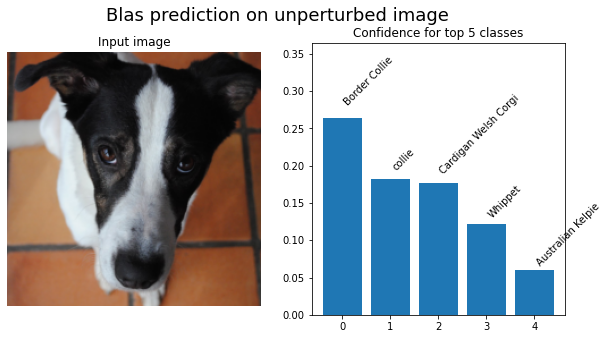

In [ ]:
blas_img = Image.open("blas_the_dog/test/blas.jpg")
blas_img = input_transform(blas_img)
y = model(blas_img)
plot_prediction(blas_img, y, title="Blas prediction on unperturbed image")

_Prediction of Blas the border collie. As we expect, the dog race is correctly classified_

### Performing a simple attack with FGSM

We now try the Fast Gradient Sign Method (FGSM). They key equation is

$$ \mathbf{\eta} = \epsilon \cdot \textrm{sign}(\nabla_\mathbf{x} J(\mathbf{\theta}, \mathbf{x}, y)) $$

Regarding the cost function $J$, I was not able to find a specific loss functio mentioned in the [original resnet paper](https://arxiv.org/pdf/1512.03385.pdf), but since it's a classification task, using `CrossEntropyLoss` is suitable, so this is what I went for. The `sign` function finds the element wise sign of the vector, and this is already implemented in pytorch.

Also, if we look at the [documentation of `ToTensor`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor), we see that when transforming a PIL image to a tensor, the values are put in the range `0.0` to `1.0`, so we would like our output ($\textrm{input}+ \eta$) to also be in this range. We therefore compute

$$
\textrm{new image} = f(\mathbf{x} + \mathbf{\eta})
$$
where $f$ is a clamping function:

$$ f = \left\{ \begin{array}{2}
1.0 & \textrm{if } x > 1.0 \\
0.0 & \textrm{if } x < 0.0 \\
x & \textrm{otherwise} \end{array}\right. $$



In [ ]:
def fgsm(input, grad, epsilon):
  """
  Adds FGSM noise to input
  """
  # find elementwise signs of gradient
  signs = grad.sign()
  # apply FGSM perturbation according to paper
  perturbed_input = input + epsilon * signs
  # The PILToTensor method in pytoch sets all the values to be in the range
  #   [0, 1], so we apply a clamp such that this range is maintained
  return torch.clamp(perturbed_input, 0, 1).detach()
  
def fgsm_perturb_image(input, label, model, epsilon,
                       criterion=nn.CrossEntropyLoss(), get_delta=False):
  """
  Performs FGSM attack on provided input with amount epsilon.

  Arguments
  ---------
  input : PIL.Image
    input image of dimensions (224, 224)
  label : str
    ImageNet class label name
  model : pytorch.nn.Module
    pytorch model that can be evaluated on input tensor in the dataset, and
    returns a tensor that matches the shape of the output tensor.
  get_delta : bool
    whether to return the perturbation as well

  Returns
  ------
  (PIL.Image, torch.tensor)
    A tuple of the perturbed image after performing the FGSM attack, and
    the noise that was added to the image.
  PIL.Image
    If `get_delta` is False
  """
  assert input.size == (224, 224)
  
  # find label ID
  label_id = torch.tensor(class_name_to_id(label)).unsqueeze(0).to(dev)

  # set up autograd
  input = to_tensor(copy.deepcopy(input)).to(dev)
  input.requires_grad = True
  model.zero_grad()

  # find the loss gradient
  y = model(input)
  loss = criterion(y, label_id)
  loss.backward()

  perturbed_input = fgsm(input, input.grad, epsilon)

  if get_delta:
    return to_pil(perturbed_input), epsilon * input.grad.sign()
  else:
    return to_pil(perturbed_input)

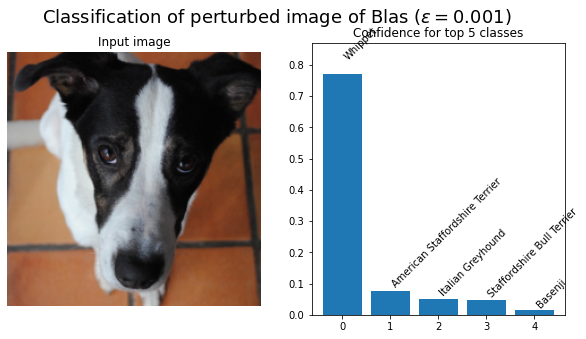

In [ ]:
blas2 = fgsm_perturb_image(blas_img, 'Border Collie', model, 0.001)
y = model(blas2)
plot_prediction(blas2, y, title=r"Classification of perturbed image of Blas ($\epsilon=0.001$)")

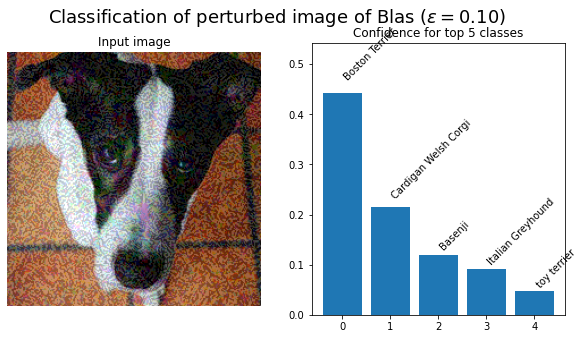

In [ ]:
blas2 = fgsm_perturb_image(blas_img, 'Border Collie', model, 0.10)
y = model(blas2)
plot_prediction(blas2, y, title=r"Classification of perturbed image of Blas ($\epsilon=0.10$)")

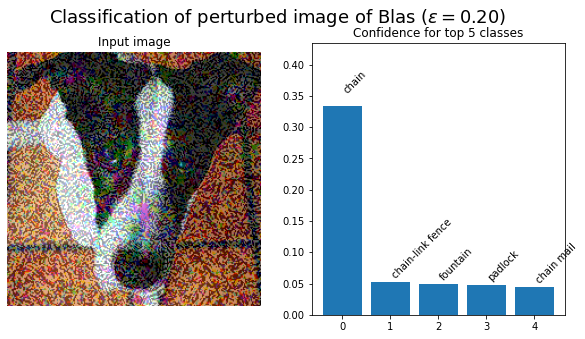

In [ ]:
blas2 = fgsm_perturb_image(blas_img, 'Border Collie', model, 0.20)
y = model(blas2)
plot_prediction(blas2, y, title=r"Classification of perturbed image of Blas ($\epsilon=0.20$)")

We are able to remove Border Collie from the top-5 predictions with a low
epsilon of 0.001, which gives minimal adversarial artifacts visible to the
human eye. However, if we want the top 5 classifications to be classes that
are clearly not dogs, we need a higher epsilon of 0.20.

In [ ]:
!wget https://www.kdnuggets.com/images/panda.png -P blas_the_dog/panda

Now, let's try using the same _giant panda_ image the FGSM paper used.

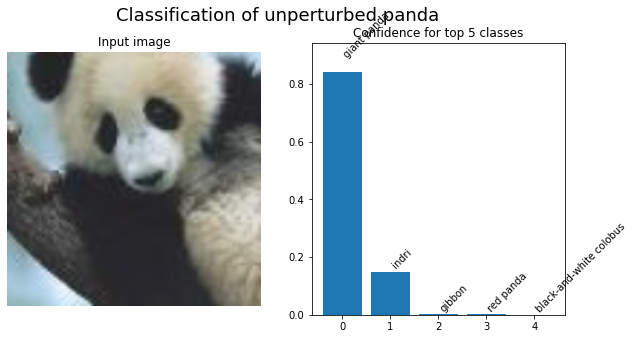

In [ ]:
panda_img = Image.open('blas_the_dog/panda/panda.png')
y = model(panda_img)
plot_prediction(panda_img, y, title="Classification of unperturbed panda")

_Resnet50 classification of unperturbed panda_

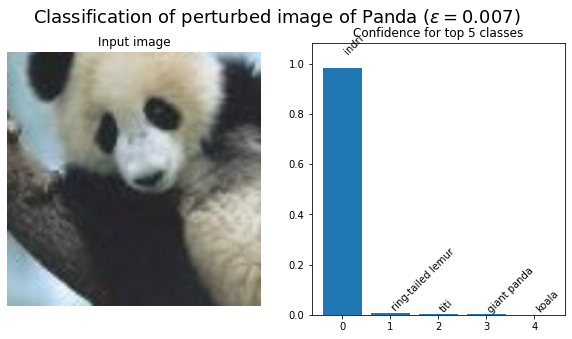

In [ ]:
giant_panda_id = class_name_to_id('giant panda')
panda2, _ = fgsm_perturb_image(panda_img, torch.tensor(giant_panda_id).unsqueeze(0),
                   model, 0.007)

y = model(panda2)
plot_prediction(panda2, y, title=r"Classification of perturbed image of Panda ($\epsilon=0.007$)")

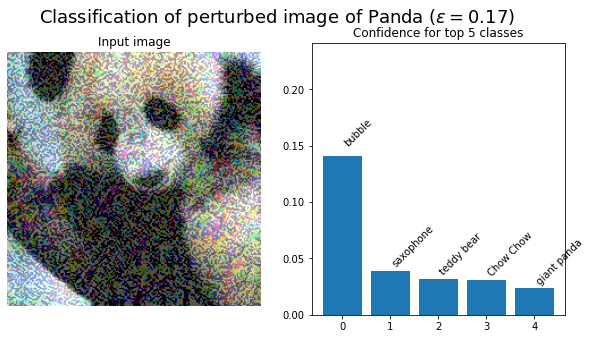

In [ ]:
giant_panda_id = class_name_to_id('giant panda')
panda2, _ = fgsm_perturb_image(panda_img, torch.tensor(giant_panda_id).unsqueeze(0),
                   model, 0.17)

y = model(panda2)
plot_prediction(panda2, y, title=r"Classification of perturbed image of Panda ($\epsilon=0.17$)")

When setting $\epsilon = 0.007$ like in the paper, we are not able to fool the model into thinking it's something that's clearly not a Panda, but are still able
to significantly reduce the confidence in the true label, "giant panda".
We also note that the paper did this attack on GoogLeNet and not Resnet-50. When we increase the $\epsilon$ a bit, we are able to make it think the panda is a bubble, which is clearly not a panda, but we clearly see some noise in the input when using this high of an $\epsilon$.

Looking at the input images with $\epsilon = 0.20$, it might be that we fool
the model just because the noise norm $\mid \eta \mid$ is so high, so what
happens if we add completely random _sign_ noise with the same magnitude?

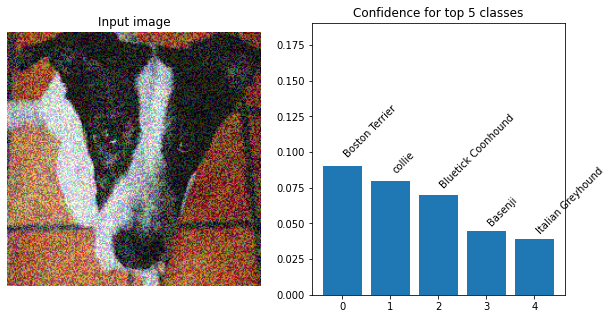

In [ ]:
epsilon = 0.20
def add_random_noise(image, epsilon):
  return torch.clamp(to_tensor(image) + epsilon *
                     torch.normal(mean=torch.zeros_like(to_tensor(image)).to(dev)).sign(), 0, 1)
noisy_blas = add_random_noise(blas_img, 0.20)
noisy_panda = add_random_noise(panda_img, 0.20)
plot_prediction(to_pil(noisy_blas), model(noisy_blas))

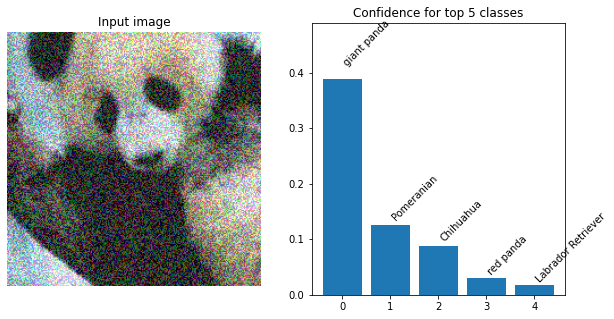

In [ ]:
plot_prediction(to_pil(noisy_panda), model(noisy_panda))

This did not cause as great of a loss in the model's performance,
so a high amount of noise is not sufficient for causing mispredictions.
We also need to be clever when it comes to the direction of
the noise, which is what FGSM achieves.

### Controlling the target class

We now move onto exploring the following:

> Can you deliberately control what class you get after the adversarial attack? (~5 marks) 

My first attempt at doing this was to just
change the original label used in the FGSM
approach i.e. use `criterion(blas_image, label('sea slug'))` when computing the signed gradient. This did not work well. My hypothesis for this is that the FGSM method only allows us to take a single "step", and we can't figure out what specific noise we need to turn the image into a 'sea slug' from just
the gradient of the loss where it's classified as a 'Border Collie'.

To get around this, we need some more sophisticated approach where we iteratively query the gradient. Taking a step back, we first notice that
we can think of the problem as an optimisation
problem where we want to solve

$$ \underset{\mathbf{\eta}}{\mathrm{argmin}} \;J(\theta,\mathbf{x}+\mathbf{\eta},\textrm{target label}),\;\; \textrm{ subject to 'small' } \eta
$$

using the same notation as above, where $J$ is our cost function.

This can be solved with gradient descent, which is what the below algorithm
is based on: We set $\mathbf{\eta}$ to be a vector of optimizable parameters and then use
torch's built-in Adam optimizer to find the suitable noise to add to the input
image. We want $|\eta|$ to be small to prevent the the image from being
perturbed too much. There are many ways to do this, such as using
regularization, normalising $\eta$ to fix the norm to a specific value, and possibly other methods
as well. However, I found the simple solution of constraining the maximum
perturbation per pixel per channel using `torch.clamp` to work well, so
that is the solution I went for:

$$ \underset{\mathbf{\eta}}{\mathrm{argmin}} \;J(\theta,\mathbf{x}+\mathbf{\eta},\textrm{target label}),\;\; \textrm{ subject to } \left(\max_{c,x,y} |(\eta_{c,x,y}|\right) < 𝜖
$$

where $𝜖$ is a hyperparameter we can control.

In [ ]:
class AdversaryModule(nn.Module):
  """
  An adverserial module whose parameters is some perturbation vector
  that can be applied to an image. The forward method applies this
  perturbation to whatever image is passed as input, clamping it to [0, 1]
  afterwards.
  
  init attributes
  -----------------
  input : tensor([x, ..., z])
    Just used to infer what size the noise tensor should be
  epsilon : float
    Maximum perturbation allowed per pixel per channel
  """
  def __init__(self, input, epsilon : float):
    super().__init__()
    self.delta = nn.Parameter(torch.zeros_like(input)).to(dev)
    self.epsilon = epsilon
  
  def forward(self, x):
    noise = None
    # This try-catch is only used to debug type errors when they occur
    #   It is not necessary when everything works
    try:
      # clamp the noise so that absolute value less than epsilon
      noise = torch.clamp(self.delta, -self.epsilon, self.epsilon)
      # add noise and clamp, like we did above, such that all values in range [0,1]
      return torch.clamp(x + noise, 0, 1)
    except Exception as e:
      print(x)
      print(noise)
      print(self.delta)
      raise e

  def get_noise(self):
    return torch.clamp(self.delta, -self.epsilon, self.epsilon)

  # Used for black box attack later
  def set_grad(self, grad):
    # .parameters() only contains one item, so we only iterate once
    for p in self.parameters():
      p.grad = grad

  # Just for utility
  def set_noise(self, noise):
    self.delta = nn.Parameter(noise).to(dev)

# Algorithm:
# * We do gradient descent with Adam on what the noise vector delta should be
# * The loss function is loss(out, target_class)
#     such that we make less panda and more whatever for instance
# * We then clamp the delta vector such that within [-e, e] for some acceptable
#     noise levels
def targeted_attack(input, target_class_name, model, epsilon,
                    criterion=nn.CrossEntropyLoss(), lr=1e-2, epochs=20,
                    get_delta=False, disable_printing=False):
  assert input.size == (224, 224)
  
  # set up autograd
  input = to_tensor(copy.deepcopy(input)).to(dev)
  input.requires_grad = True
  # model.zero_grad()

  target_label = class_name_to_id(target_class_name)
  out = model(input)
  original_label, p = top_5_classes(out)[0]
  if not disable_printing:
    print(f"Unperturbed image classified as '{original_label}' with confidence p={p:.4}")
  original_label = class_name_to_id(original_label)

  target_tensor = torch.tensor(target_label).unsqueeze(0).to(dev)
  original_tensor = torch.tensor(original_label).unsqueeze(0).to(dev)

  delta = AdversaryModule(input, epsilon)
  optimizer = torch.optim.Adam(delta.parameters(), lr=lr)

  # simple train loop
  for i in range(epochs):
    optimizer.zero_grad()
    out = model(delta.forward(input))
    loss = criterion(out, target_tensor) #- criterion(out, original_tensor)
    loss.backward()
    optimizer.step()

    # Print statistics
    # out = model(delta.forward(input))
    if not disable_printing:
      print(f"Epoch {i + 1} / {epochs}:")
      orig_prob = probability_of_class(out.detach(), original_label)
      target_prob = probability_of_class(out.detach(), target_label)
      print(f"  Prob({class_id_to_name(original_label)}) = {orig_prob:.4}")
      print(f"  Prob({class_id_to_name(target_label)}) = {target_prob:.4}")
      print(f"  Noise norm: {torch.linalg.norm(delta.get_noise()).item():.4}")
      print(f"  Max noise per pixel: {torch.max(delta.get_noise()).item():.4}")

  new_image = delta.forward(input)
  # just return the perturbation
  if get_delta:
    return to_pil(new_image), delta.get_noise()
  # perturb the image and then return it
  else:
    return to_pil(new_image)

Now that we've implemented our adverserial algorithm, we can then see if we can make Blas be classified as a 'sea slug'.

Unperturbed image classified as 'Border Collie' with confidence p=0.2645
Epoch 1 / 5:
  Prob(Border Collie) = 0.007937
  Prob(sea slug) = 0.0003256
  Noise norm: 3.881
  Max noise per pixel: 0.01
Epoch 2 / 5:
  Prob(Border Collie) = 0.00606
  Prob(sea slug) = 0.01162
  Noise norm: 3.676
  Max noise per pixel: 0.01
Epoch 3 / 5:
  Prob(Border Collie) = 0.00324
  Prob(sea slug) = 0.1812
  Noise norm: 3.609
  Max noise per pixel: 0.01
Epoch 4 / 5:
  Prob(Border Collie) = 0.0009461
  Prob(sea slug) = 0.6344
  Noise norm: 3.688
  Max noise per pixel: 0.01
Epoch 5 / 5:
  Prob(Border Collie) = 0.0003651
  Prob(sea slug) = 0.8094
  Noise norm: 3.754
  Max noise per pixel: 0.01


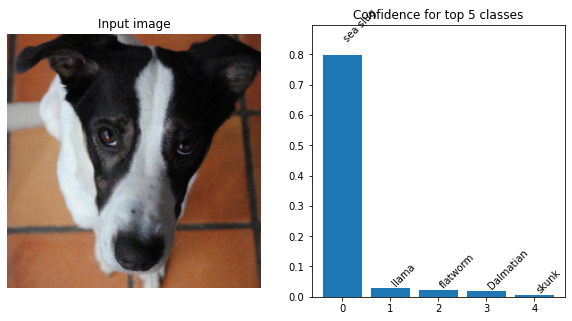

In [ ]:
perturbed_blas = targeted_attack(blas_img, 'sea slug', model, epsilon=0.01,
                                 lr=1e-2, epochs=5)
y = model(perturbed_blas)
plot_prediction(perturbed_blas, y)

This worked suprisingly well. We are able to cause misclassifications with just
$\epsilon = 0.01$, which did not give major misclassifications with the FGSM
approach. Moreover, the network is very confident that Blas is a sea slug,
despite it clearly looking like a dog to the human eye (I am unable to spot
any adversarial artifacts at all).

In [(Szegedy et al, 2013)](https://arxiv.org/pdf/1412.6572.pdf), they say

> The direction of perturbation, rather than the specific point in space, matters most. Space is
not full of pockets of adversarial examples that finely tile the reals like the rational numbers.

This might explain why this method works so well: We are spending all our
effort learning (by optimization) the _direction_ to perturb the image.


As a small check, we can check if this method works for other images and labels
as well, trying it on the giant panda image.

Unperturbed image classified as 'giant panda' with confidence p=0.8428
Epoch 1 / 6:
  Prob(giant panda) = 0.4171
  Prob(vending machine) = 4.956e-05
  Noise norm: 0.3877
  Max noise per pixel: 0.001
Epoch 2 / 6:
  Prob(giant panda) = 0.1337
  Prob(vending machine) = 0.001156
  Noise norm: 0.6397
  Max noise per pixel: 0.002001
Epoch 3 / 6:
  Prob(giant panda) = 0.04766
  Prob(vending machine) = 0.005277
  Noise norm: 0.8537
  Max noise per pixel: 0.003005
Epoch 4 / 6:
  Prob(giant panda) = 0.03353
  Prob(vending machine) = 0.02039
  Noise norm: 1.037
  Max noise per pixel: 0.004011
Epoch 5 / 6:
  Prob(giant panda) = 0.02975
  Prob(vending machine) = 0.09105
  Noise norm: 1.198
  Max noise per pixel: 0.00502
Epoch 6 / 6:
  Prob(giant panda) = 0.01736
  Prob(vending machine) = 0.3136
  Noise norm: 1.345
  Max noise per pixel: 0.006028


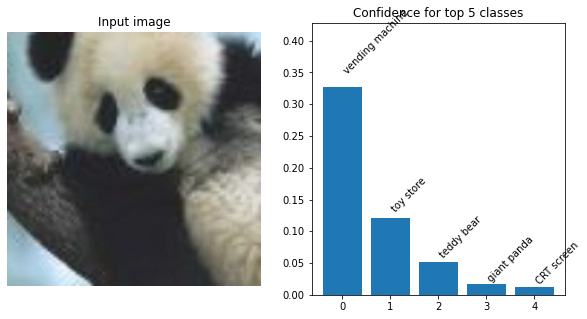

In [ ]:
perturbed_panda = targeted_attack(panda_img, 'vending machine', model,
                                  epsilon=0.007, lr=1e-3, epochs=6)
y = model(perturbed_panda)
plot_prediction(perturbed_panda, y)

I tried repeating the attack on the panda image, using
a very small $\epsilon$, and it was able to turn it into
a vending machine. However, it still puts 'giant panda'
in the top 5 classes. A further optimisation to our
algorithm would be to change the loss function to
something like

$$ \underset{\mathbf{\eta}}{\mathrm{argmin}} \;\left(J(\theta,\mathbf{x}+\mathbf{\eta},\textrm{target label})
- J(\theta, \mathbf{x}+\mathbf{\eta},\textrm{original label})
\right).
$$

That way, we also make the noise decrease the confidence in the original prediction while making the targeted prediction more likely.

Unperturbed image classified as 'giant panda' with confidence p=0.8428
Epoch 1 / 8:
  Prob(giant panda) = 0.8428
  Prob(vending machine) = 1.387e-07
  Noise norm: 0.388
  Max noise per pixel: 0.001
Epoch 2 / 8:
  Prob(giant panda) = 0.3053
  Prob(vending machine) = 3.516e-05
  Noise norm: 0.6415
  Max noise per pixel: 0.002001
Epoch 3 / 8:
  Prob(giant panda) = 0.05516
  Prob(vending machine) = 0.000628
  Noise norm: 0.8601
  Max noise per pixel: 0.003005
Epoch 4 / 8:
  Prob(giant panda) = 0.01112
  Prob(vending machine) = 0.002636
  Noise norm: 1.054
  Max noise per pixel: 0.004011
Epoch 5 / 8:
  Prob(giant panda) = 0.003128
  Prob(vending machine) = 0.005876
  Noise norm: 1.23
  Max noise per pixel: 0.00502
Epoch 6 / 8:
  Prob(giant panda) = 0.0009812
  Prob(vending machine) = 0.01401
  Noise norm: 1.39
  Max noise per pixel: 0.006031
Epoch 7 / 8:
  Prob(giant panda) = 0.0002731
  Prob(vending machine) = 0.03694
  Noise norm: 1.537
  Max noise per pixel: 0.007
Epoch 8 / 8:
  Prob(gia

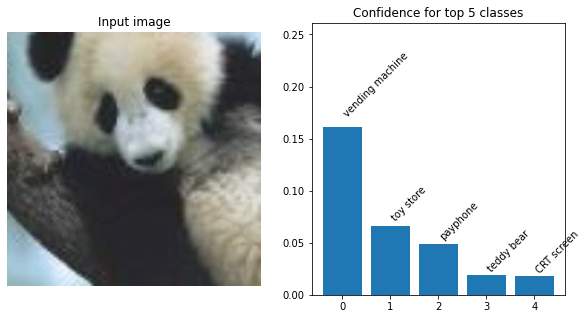

In [ ]:
crit = nn.CrossEntropyLoss()
def more_target_less_panda(out, target_label):
  panda_label = torch.scalar_tensor(class_name_to_id('giant panda')).unsqueeze(0).type(torch.LongTensor).to(dev)
  return crit(out, target_label) - crit(out, panda_label)

perturbed_panda = targeted_attack(panda_img, 'vending machine', model,
                                  epsilon=0.007, lr=1e-3, epochs=8, criterion=more_target_less_panda)
plot_prediction(perturbed_panda, model(perturbed_panda))


To check how well this approach generalises, we can do a more quantitative
experiment. We randomly pick out 50 random images from the ImageNet dataset
and pick 10 random ImageNet labels that we use as targets. We then
measure our Top-1 and Top-5 success rate i.e. how often we are able to make
the target label appear in Resnet's top $k$ most confident predictions.

In [ ]:
# See section "Setting up mini-ImageNet" for the details of how the method
#   get_dataset(str, float) was implemented

def evaluate_targeted_gd_attack(epsilon, prop_test_data, num_labels=10, epochs=3):
  # See section "Setting up mini-ImageNet" for the details of this method
  test_ds = get_dataset("test", prop_test_data)
  print(f"Evaluating FGSM on {len(test_ds)} test images from ImageNet")
  top_1_rate_total = 0
  top_5_rate_total = 0

  for i in np.random.permutation(1000)[:num_labels]:
    print(f"Targeting label '{class_id_to_name(i)}' with id={i}")
    target_label = class_id_to_name(i)
    target_tensor = torch.scalar_tensor(i).to(dev)

    top_1_rate = 0
    top_5_rate = 0
    # we are targeting a label, so ignore true label
    for test_img, _ in test_ds:
      perturbed_img = targeted_attack(to_pil(test_img), target_label, model,
                                      epsilon, epochs=epochs, disable_printing=True)
      p =  softmax(model(perturbed_img)[0,:], dim=0)
      # top 1
      if p.topk(1)[1][0] == target_tensor:
        top_1_rate += 1
      if target_tensor in p.topk(5)[1]:
        top_5_rate += 1

    print(f"  Top-1 success rate: {top_1_rate/len(test_ds):.3}")
    print(f"  Top-5 success rate: {top_5_rate/len(test_ds):.3}")
    
    top_1_rate_total += top_1_rate
    top_5_rate_total += top_5_rate
  
  top_1_rate_total /=  num_labels * len(test_ds)
  top_5_rate_total /=  num_labels * len(test_ds)
  print(f"Overall top-1 success rate: {top_1_rate_total:.3}")
  print(f"Overall top-5 success rate: {top_5_rate_total:.3}")

evaluate_targeted_gd_attack(epsilon=0.07, prop_test_data=1/240)

Evaluating FGSM on 50 test images from ImageNet
Targeting label 'window screen' with id=904
  Top-1 success rate: 0.88
  Top-5 success rate: 0.96
Targeting label 'modem' with id=662
  Top-1 success rate: 0.86
  Top-5 success rate: 0.88
Targeting label 'pillow' with id=721
  Top-1 success rate: 0.96
  Top-5 success rate: 0.98
Targeting label 'safe' with id=771
  Top-1 success rate: 0.86
  Top-5 success rate: 0.92
Targeting label 'radiator' with id=753
  Top-1 success rate: 0.9
  Top-5 success rate: 0.96
Targeting label 'hot pot' with id=926
  Top-1 success rate: 0.5
  Top-5 success rate: 0.68
Targeting label 'wig' with id=903
  Top-1 success rate: 0.88
  Top-5 success rate: 0.94
Targeting label 'Curly-coated Retriever' with id=206
  Top-1 success rate: 0.72
  Top-5 success rate: 0.86
Targeting label 'tow truck' with id=864
  Top-1 success rate: 0.84
  Top-5 success rate: 0.88
Targeting label 'stone wall' with id=825
  Top-1 success rate: 0.62
  Top-5 success rate: 0.72
Overall top-1 suc

The approach generalises fairly well as we get successful
adverserial attacks over 80% of the time, even when both the input
images and target labels are random.

#### Improving our initial untargeted attack

If we look more closely at the improved targeted attack cost function,

$$ \underset{\mathbf{\eta}}{\mathrm{argmin}} \;\left(J(\theta,\mathbf{x}+\mathbf{\eta},\textrm{target label})
- J(\theta, \mathbf{x}+\mathbf{\eta},\textrm{original label})
\right),
$$

we notice that a variant of this can be used to perform an efficient
non-targeted attack. We simply set the loss to be how far we are away from
the original classification, and then maximise this:

$$ \underset{\mathbf{\eta}}{\mathrm{argmin}} \;
- J(\theta, \mathbf{x}+\mathbf{\eta},\textrm{original label}).
$$

We define an attack using this, recognizing it as a special case of our
targeted attack algorithm:

Unperturbed image classified as 'Border Collie' with confidence p=0.2645
Epoch 1 / 3:
  Prob(Border Collie) = 0.2645
  Prob(Border Collie) = 0.2645
  Noise norm: 0.388
  Max noise per pixel: 0.001
Epoch 2 / 3:
  Prob(Border Collie) = 0.001695
  Prob(Border Collie) = 0.001695
  Noise norm: 0.3475
  Max noise per pixel: 0.001
Epoch 3 / 3:
  Prob(Border Collie) = 0.0005372
  Prob(Border Collie) = 0.0005372
  Noise norm: 0.3432
  Max noise per pixel: 0.001


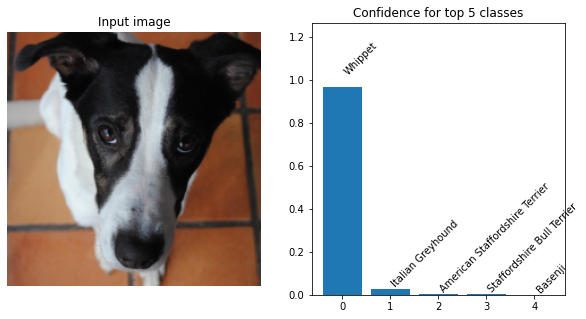

In [ ]:
def gradient_descent_attack(input, target_class_name, model, epsilon, lr=1e-3,
                            epochs=20, get_delta=False, disable_printing=False):
  """
  The `target_class_name` is the label associated with `input`
  """
  crit = nn.CrossEntropyLoss().to(dev)
  def criterion(model_out, label):
    return -crit(model_out, label)
  return targeted_attack(input, target_class_name, model, epsilon,
                         lr=lr, epochs=epochs, get_delta=get_delta,
                         criterion=criterion, disable_printing=disable_printing)

perturbed_blas = gradient_descent_attack(blas_img, 'Border Collie', model, epsilon=0.001, epochs=3)
plot_prediction(perturbed_blas, model(perturbed_blas))

Unperturbed image classified as 'giant panda' with confidence p=0.8428
Epoch 1 / 3:
  Prob(giant panda) = 0.02175
  Prob(giant panda) = 0.02175
  Noise norm: 0.388
  Max noise per pixel: 0.001
Epoch 2 / 3:
  Prob(giant panda) = 0.0002929
  Prob(giant panda) = 0.0002929
  Noise norm: 0.5847
  Max noise per pixel: 0.002001
Epoch 3 / 3:
  Prob(giant panda) = 3.905e-06
  Prob(giant panda) = 3.905e-06
  Noise norm: 0.7744
  Max noise per pixel: 0.003005


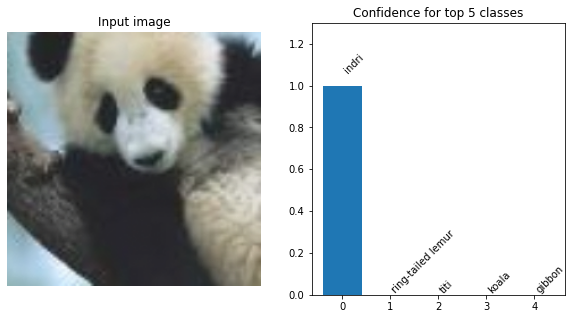

In [ ]:
perturbed_panda = gradient_descent_attack(panda_img, 'giant panda', model, epsilon=0.007, epochs=3)
plot_prediction(perturbed_panda, model(perturbed_panda))

This successfully fools the network while
adding minimal adversarial artifacts.

### Blackbox attacks

We now explore the following question:

> Can you generate adversarial examples without access to gradients, only using the forward pass of the network (this is called black-box adversarial attack)? (~10 marks)


If we don't have access to the gradient $  \nabla_\mathbf{x} J(\mathbf{\theta}, \mathbf{x}, y) $, I can  think of three approaches to an adverserial attack:
1. Find some universal noise that should always fool the network
2. _Estimate_ what the gradient is through repeated queries, then use the estimated value to perform e.g. FGSM or gradient descent
3. Perform some form of iterated descent to optimize the noise vector $\eta$, using blackbox queries to figure out when to step

Approach 1 has some exploration oppurtunities, but I have not pursued these.
This section is thereby structured as follows: I first explore approach 2,
where I start by estimating what the gradient is at a certain point
$\mathbf{x}$. I then use this to do a FGSM adversarial attack. After this,
I use the `estimate_gradient` routine to do an estimated gradient descent,
similar to the `gradient_descent_attack` above. After this, I realise that
both of these methods are either not very computationally efficient or does not produce nice-looking results,
so I simplify my approach, arriving at `blackbox_iterated_descent`, which
turns out to be very simple, and is more akin to approach 3.
Finally, I use a variant of `blackbox_iterated_descent` to achieve a 
_targeted attack_.



#### Estimating the gradient

I recall one definition of the differentiation:

$$ f'(x) = \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x)-f(x)}{\Delta x} $$

and how this can used to approximate differentials:

$$ f'(x) \approx \frac{f(x+\Delta x)-f(x)}{\Delta x}, \textrm{ for small } \Delta x > 0. $$

If we look at this equation more closely, we notice that it can be evaluated through only _blackbox_ queries to the function $f$.  
However, the $x$ here is 1-dimensional, but the images we feed into our model
are of $3*224*224=150528$ dimensions and we don't have time to make two queries
for each of the dimensions. The question then becomes: How to we
find a clever choice for $\Delta x$?  With inspiration from [Natural Evolution Strategies](https://en.wikipedia.org/wiki/Natural_evolution_strategy) (NES), we can think of $\Delta x$ as a random variable sampled from some distribution $p (\cdot \mid \theta)$, parameterised by $\theta$.

Before we move on, let's define our
notation in terms of adverserial image attacks: Consider some neural
network $N_\theta$, parameterised by $\theta$, with cost function $J$. Let $\mathbf{x}$ be the input image and $y$ the correct label 
associated with the input image, such that $J(\theta, \mathbf{x}, y)$
is the loss (we would write $J$ as `criterion(model(x), y)` in code).
Let then $\mathbf{\eta}$ be the random variable for the noise added
to the image, such that $\mathbf{x'} ≜ \mathbf{x}+\mathbf{\eta}$ is the
random variable for the perturbed image. We let $\mathbf{x'}$ be sampled
from some distribution $p(\cdot \mid \mathbf{x})$, parameterised by $\mathbf{x}$, the unperturbed image (with the constraint that the mean is $\mathbf{x}$).

We can then write:

$$ J(\theta, \mathbf{x}, y) =
\mathbf{E}_{\mathbf{x'} \sim p_\mathbf{x}} [ J(\theta, \mathbf{x'}, y)]
= \int J(\theta, \mathbf{x'}, y) \cdot p(\mathbf{x'} \mid \mathbf{x}) \;\textrm{d} \mathbf{x'} $$

With inspiration from NESs again, we derive:

\begin{align}
\nabla_\mathbf{x} J(\theta, \mathbf{x}, y) & =
\nabla_\mathbf{x} \int J(\theta, \mathbf{x'}, y) \cdot p(\mathbf{x'} \mid \mathbf{x})\; \textrm{d}\mathbf{x'} \\
& = \int J(\theta, \mathbf{x'}, y) \cdot \nabla_\mathbf{x} p(\mathbf{x'}\mid \mathbf{x}) \cdot \frac{p(\mathbf{x'} \mid \mathbf{x})}{p(\mathbf{x'} \mid \mathbf{x})} \; \textrm{d} \mathbf{x'} \\
& = \int \left( J(\theta, \mathbf{x'}, y) \cdot \nabla_\mathbf{x} \log p(\mathbf{x'} \mid \mathbf{x}) \right) p(\mathbf{x'} \mid \mathbf{x})
\; \textrm{d} \mathbf{x'} \\
& = \mathbf{E}_{\mathbf{x'} \sim p_\mathbf{x}} \left[ J(\theta, \mathbf{x'}, y) \cdot \nabla_\mathbf{x} \log p(\mathbf{x'} \mid \mathbf{x} ) \right]
\end{align}

This expectation can then be approximated with Monte Carlo sampling
where we choose suitable $p(\cdot \mid \mathbf{x})$ for our samples:

$$ \nabla_\mathbf{x} J(\theta, \mathbf{x}, y) ≈
\frac{1}{n} \sum_{k=1}^n J(\theta, x'_k, y) \nabla_\mathbf{x} \log p(x'_k \mid \mathbf{x}) $$

**Choice of $p$**

To start of, we can try adding independent gaussian noise to each pixel
of our image in each channel. This gives

$$
\mathbf{x'} \sim \mathcal{N}(\mu=\mathbf{x},\sigma=\sigma_0)
$$
for some hyperparameter $\sigma_0$. To calculate
$\nabla_\mathbf{x} \log p(x'_k \mid \mathbf{x}) $, I use the autograd
library in torch, using the negation of `GaussianNLLLoss` as our implementation
of the log likelihood of the gaussian PMF. I also tried to use the analaytical
solution to $\nabla_\mathbf{x} \log \textrm{pmf}_\mathcal{N}$, instead of
autograd, but this did not work as well. This might be due to me missing
a nuance in tensor calculus when deriving, or there's some additional aspects of
`GaussianNLLLoss` that makes it work better.

**Evaluating the estimation**

To evaluate how good our estimate of the gradient is, I flatten both the
real and estimated gradient into a vector, normalize them, then compute the
dot product. This should give some measure of how much they "overlay", so the
closer the value is to 1.0, the better the estimation is. Since I am doing
a FGSM attack using the estimated gradient, I also look at the proportion of
signs that are correct when computing the `grad.sign()` for the estimated
grad compared to the real gradient.

Another way of evaluating our attack, is to see how likely Blas is to be
classified as a dog at each iteration. If we look at a [ImageNet class list](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/), we see that classes `151` to `275` (inclusive) are all dog breeds, so we can
plot the sum of the confidence for all the dog breeds, as well as the
most confident dog prediction.

**Note on `no_grad`**

To ensure I don't have access to the gradients, all queries to `model` are
performed within a `with torch.no_grad()` environment.

In [ ]:
import torch.nn.functional as F

class BlackboxMetricTracker():
  """
  This class is just used to track various metrics such that they can
  be plotted later.
  """
  def __prob_dog(self, input):
    # See ImageNet label descriptions
    dog_ids = range(151, 276)
    non_dog_ids = [x for x in range(0, 1000) if x not in dog_ids]
    # make prediction
    out = self.model(input)
    out = torch.Tensor.cpu(out)
    # model_out = model(torch.clamp(copy.deepcopy(input) + est_grad.sign() * epsilon, 0, 1))
    p = softmax(out[0,:], dim=0)
    p_dog = sum([p[i] for i in dog_ids])
    p_dog_max = max([p[i] for i in dog_ids])
    top_p = max(p)
    return p_dog, p_dog_max, top_p
  
  def __init__(self, model, grad_metrics=False, real_grad=None, track_dog_stats=True):
    self.track_dog_stats = track_dog_stats
    self.grad_metrics = grad_metrics
    self.model = model
    if grad_metrics == True:
      assert real_grad is not None
      self.real_grad = torch.Tensor.cpu(copy.deepcopy(real_grad))

    # for the plot
    self.xs = []
    self.p_dogs = []
    self.p_dog_maxs = []
    self.top_ps = []
    self.norm_metric = []
    self.sign_metric = []
  
  def track(self, x, input, est_grad=None):
    """
    Record current metrics, adding them to a list that can be later used for plot
    """
    p_dog, p_dog_max, top_p = self.__prob_dog(input)
    self.xs.append(x)
    self.p_dogs.append(p_dog)
    self.p_dog_maxs.append(p_dog_max)
    self.top_ps.append(top_p)
    if self.grad_metrics:
      assert est_grad is not None
      est_grad = torch.Tensor.cpu(est_grad)
      est_flat = torch.Tensor.cpu(torch.flatten(est_grad))
      real_flat = torch.flatten(self.real_grad)
      metric_norm = torch.dot(F.normalize(est_flat, dim=0),
                              F.normalize(real_flat, dim=0))
      # If same, elementwise mult gives 1, othw. -1, so count 1s by adding 1 and
      #    then dividing by 2
      num_signs_correct = torch.sum((real_flat.sign() * est_flat.sign() + 1) / 2)
      self.sign_metric.append(num_signs_correct / est_flat.size()[0])
      self.norm_metric.append(metric_norm)

  def plot(self, ax, ax2=None, title=None, title2=None, plot_kwargs=None):
    assert len(self.p_dogs) > 0
    if ax2 is None:
      ax2 = ax
    if plot_kwargs is None:
      plot_kwargs={}

    if self.track_dog_stats:
      ax.plot(self.xs, self.p_dogs, label="Probability of dog", **plot_kwargs)
      ax.plot(self.xs, self.p_dog_maxs, label="Highest dog probability", **plot_kwargs)

    ax.plot(self.xs, self.top_ps,  label="Highest confidence prediction", **plot_kwargs)
    ax2.plot(self.xs, self.norm_metric, label="Norm of estimated gradiant projected onto real gradient", **plot_kwargs)
    ax2.plot(self.xs, self.sign_metric,  label="Proportion of correct signs", **plot_kwargs)

    ax.set_xlabel("Number of queries")
    ax.set_ylabel("Probability")
    ax.legend()
    ax.set_ylim([0,1])
    if title is not None:
      ax.set_title(title)
    ax2.set_xlabel("Number of queries")
    ax2.set_ylabel("Norm/Proportion")
    ax2.legend()
    ax2.set_ylim([0,1])
    if title2 is not None:
      ax2.set_title(title2)

def estimate_gradient(model, input, label, num_samples, batch_size, sigma,
                      criterion=nn.CrossEntropyLoss(), tracker=None, tracker_kwargs=None):
  """
  Estimate the gradient of 
  
      criterion(model(input), label)
      
  w.r.t. `input`, using Monte Carlo sampling with n = `num_samples`.
  See maths description above. The gaussian distribution
  used uses the hyperparameter sigma_0 = `sigma`.

  The samples are done in batches of size `batch_size` to speed up computation.
  """
  if tracker is not None:
    assert 'real_grad' in tracker_kwargs
    assert 'perturb_f' in tracker_kwargs

  input = copy.deepcopy(input).to(dev)

  log_prob = nn.GaussianNLLLoss(full=True, reduction='sum').to(dev)
  # This ensures we don't accidently treat the model as a whitebox
  #   as it disables all use og gradient access
  with torch.no_grad():
    if tracker is not None:
      # baseline on unperturbed image
      tracker.track(0, input, torch.zeros_like(tracker_kwargs['real_grad']))

    sum = torch.zeros_like(input).to(dev)

    # run the samples through the model in a batch for parallelisation, but
    #   limit to 100 samples at a time to not run out of memory
    for i in range(0, num_samples, batch_size):
      # TODO: There's probably a DataLoader approach to do this...
      input_batches = input.unsqueeze(0).repeat(
          min(batch_size, num_samples - batch_size * int(i / batch_size)), 1, 1, 1)
      # These are vectors of images with added noise, see $x'$ in formulas above
      x_primes = torch.normal(mean=input_batches, std=torch.scalar_tensor(sigma).to(dev)).to(dev)
        # whitebox query the model
      outs = model(x_primes).detach()

      for k in range(input_batches.size()[0]):
        x_prime = x_primes[k]
        out = outs[k].unsqueeze(0)
    
        log_prob_grad = None
        # we need gradient just for the probability distribution calulation,
        #   and we don't mention the `model` in this scope, so it's still blackbox
        with torch.enable_grad():
          # not performing a copy here gave some weird bugs, so
          #   I left it here instead of figuring out why. It shouldn't be necessary
          input_copy = copy.deepcopy(input)
  
          log_prob.zero_grad()
          input_copy.requires_grad = True
          var_arg = torch.ones_like(input_copy) * torch.scalar_tensor(sigma)
          val = log_prob(x_prime, input_copy, var_arg)
          val.backward()
          # the loss function used negates the result, so reverse that
          log_prob_grad = -1 * input_copy.grad

        sum += - criterion(out, label) * log_prob_grad

      if tracker is not None:
        # save metrics to tracker
        est_grad = sum / (i + input_batches.size()[0])
        tracker.track(i + input_batches.size()[0],
                      tracker_kwargs['perturb_f'](input, est_grad), est_grad)
    
    # estimate gradient after all the Monte Carlo samples
    return sum / num_samples
  
def blackbox_fgsm_attack(input, label, model, epsilon, criterion=nn.CrossEntropyLoss(),
                         num_samples=100, sigma=0.01, batch_size=50):
  """
  Performs FGSM attack on provided input with epsilon, without querying the
  gradient of the loss w.r.t. the model input.

  Arguments
  ---------
  input : PIL.Image
    input image of dimensions (224, 224)
  model : pytorch.nn.Module
    pytorch model that can be evaluated on input tensor in the dataset, and
    returns a tensor that matches the shape of the output tensor.

  Returns
  ------
  (PIL.Image, torch.tensor)
    A tuple of the perturbed image after performing the FGSM attack, and
    the noise that was added to the image.
  """
  assert input.size == (224, 224)

  # transformations
  to_tensor = transforms.ToTensor()
  to_pil = transforms.ToPILImage()

  # set up autograd
  input = to_tensor(copy.deepcopy(input)).to(dev)
  input.requires_grad = True
  model.zero_grad()

  label = torch.tensor(class_name_to_id(label)).unsqueeze(0).to(dev)

  # find the real loss gradient (just used for comparison)
  y = model(input)
  loss = criterion(y, label)
  loss.backward()
  real_grad = input.grad.detach()

  # We have use the above real gradient to compare with subsequent estimations
  tracker = BlackboxMetricTracker(model, grad_metrics=True, real_grad=real_grad)

  est_grad = estimate_gradient(model, input, label, num_samples, batch_size,
                               sigma, criterion, tracker, {
                                   "real_grad" : real_grad,
                                   "perturb_f" : lambda input, est: fgsm(input, est, epsilon),
                               })
  # Now do FGSM with the estimation of the gradient
  perturbed_input = fgsm(input, est_grad, epsilon)

  return to_pil(perturbed_input), tracker

####Blackbox FGSM examples

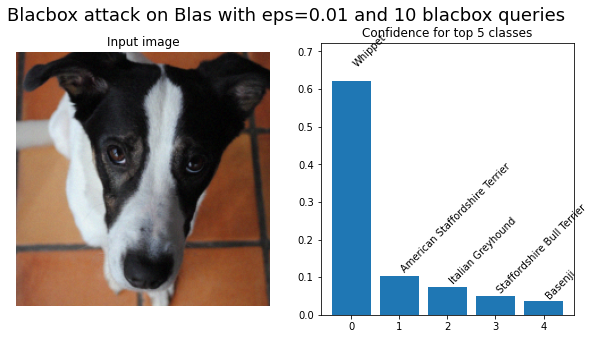

In [ ]:
out, _ = blackbox_fgsm_attack(blas_img, 'Border Collie', model, 0.01,
                                   num_samples=10, sigma=1, batch_size=50)
plot_prediction(out, model(out), title="Blacbox attack on Blas with eps=0.01 and 10 blacbox queries")

We are able to fool the model into not putting Border Collie in the top-5 prediction with just doing 10 samples
and using $\epsilon=0.01$. However, if we want the model
to think of Blas as something that's clearly not a dog,
we need more samples and higher $\epsilon$. Additionally,
this attack only sometimes work; We may get unlucky with
our MC samples, preventing us from perturbing the top-5
accuracy.

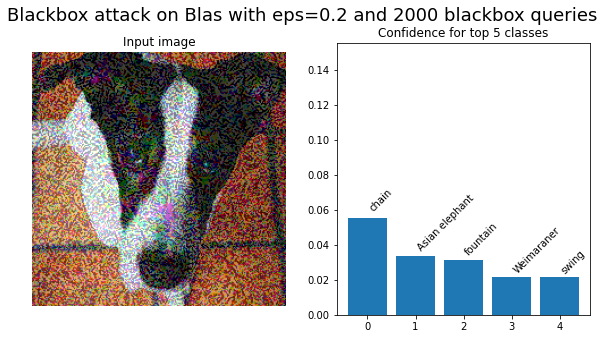

In [ ]:
out, _ = blackbox_fgsm_attack(blas_img, 'Border Collie', model, 0.20,
                                   num_samples=2000, sigma=1, batch_size=50)
plot_prediction(out, model(out), title="Blackbox attack on Blas with eps=0.2 and 2000 blackbox queries")

With more queries and higher epsilon, we can create
structured noise causing resnet50 to predict Blas
as something that's clearly not a dog. This is seen in the plot below
and above.

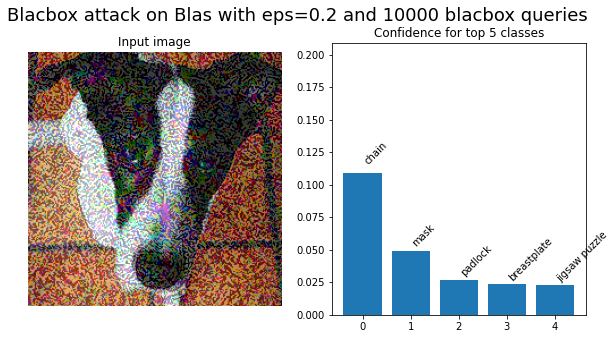

In [ ]:
out, tracker = blackbox_fgsm_attack(blas_img, 'Border Collie', model, 0.20,
                           num_samples=10000, sigma=1, batch_size=50)
plot_prediction(out, model(out), title="Blacbox attack on Blas with eps=0.2 and 10000 blacbox queries")

Going back to what I said in the "Evaluating the
estimation" in the introduction, we can now look at
how good the gradient estimation is after different number of queries.
We do 100 000 blacbox queries and track various metrics every 50th query.

In [ ]:
_, tracker = blackbox_fgsm_attack(blas_img, 'Border Collie', model, 0.20,
                                  num_samples=100000, sigma=1, batch_size=50)

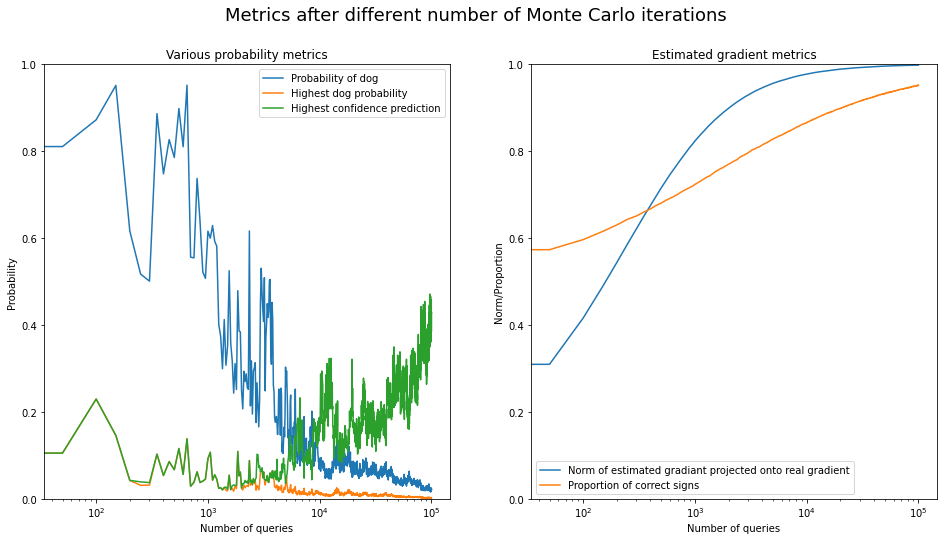

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
tracker.plot(axs[0], axs[1], title="Various probability metrics", title2="Estimated gradient metrics")
axs[0].set_xscale('log')
axs[1].set_xscale('log')
fig.suptitle("Metrics after different number of Monte Carlo iterations", fontsize=18)
plt.show()

_Figure: Log-plot of various metrics for the gradient estimation as well as the FGSM attack performed with that gradient. The x-axis is the total number of blackbox queries made. At x=0, the estimated gradient is all zeros_

If we look at the right plot, we require an exponential number of queries to
improve our estimated gradient by a fixed amount. At least, this is the case
at the start. When we are nearing the real gradient, our estimated improves
even slower with the number of queries.

We also see that the projection metric is almost 1 when we get close to 100 000 queries. This shows how computationally expensive it is to get a nearly
perfect estimate of the gradient, so it's not feasible if we require the
gradient many times.

It also takes many thousands queries before we can make a non-dogg class be the
most confident prediction.

#### Incorporating gradient descent

In "Controlling the target class", we saw that using gradient descent to find
the perturbation gave much more flexibility in terms of controlling what
predictions appear in the top-5, compared to FGSM. Now that we
have a procedure to `estimate_gradient`, we can try combining it with our
"gradient descent" algorithm.


In [ ]:
def black_box_estimated_gradient_descent(input, label, model, epsilon,
                    criterion=nn.CrossEntropyLoss(), lr=1e-3, num_steps=20,
                    num_queries_per_grad=300):
  assert input.size == (224, 224)
  
  # transformations
  to_tensor = transforms.ToTensor()
  to_pil = transforms.ToPILImage()

  input = to_tensor(copy.deepcopy(input)).to(dev)
  label = torch.tensor(class_name_to_id(label)).unsqueeze(0).to(dev)

  out = model(input)
  original_label, p = top_5_classes(out)[0]
  print(f"Unperturbed image classified as '{original_label}' with confidence p={p:.4}")
  original_label = class_name_to_id(original_label)

  adversary = AdversaryModule(input, epsilon)
  optimizer = torch.optim.Adam(adversary.parameters(), lr=lr)

  with torch.no_grad():
    # simple train loop
    for i in range(num_steps):
      optimizer.zero_grad()
      out = model(adversary.forward(input))
      # Negate the result because we want to increase the loss if answer
      #   is really Border Collie when we take a `.step()`
      est_grad = -estimate_gradient(model, adversary.forward(input), label,
                                    num_samples=num_queries_per_grad,
                                    batch_size=50, sigma=1, criterion=criterion)
      # use estimated gradient instead of doing .backward() and .grad
      with torch.enable_grad():
        adversary.set_grad(est_grad)
      optimizer.step()

      # Print statistics
      out = model(adversary.forward(input))
      print(f"Step {i + 1} / {num_steps}:")
      # print(f"  {next(adversary.parameters())}")
      orig_prob = probability_of_class(out, 'Border Collie')
      # target_prob = probability_of_class(out, target_label)
      print(f"  Prob({class_id_to_name(original_label)}) = {orig_prob:.4}")
      # print(f"  Prob({class_id_to_name(target_label)}) = {target_prob:.4}")
      print(f"  Noise norm: {torch.linalg.norm(adversary.get_noise()).item():.4}")
      print(f"  Max noise per pixel: {torch.max(adversary.get_noise()).item():.4}")

  new_image = adversary.forward(input)
  return to_pil(new_image)

In [ ]:
out = black_box_estimated_gradient_descent(blas_img, 'Border Collie', model, 0.1,
                                 lr=1e-2, num_steps=30, num_queries_per_grad=1000)

Unperturbed image classified as 'Border Collie' with confidence p=0.2645
Step 1 / 30:
  Prob(Border Collie) = 0.1697
  Noise norm: 3.88
  Max noise per pixel: 0.01
Step 2 / 30:
  Prob(Border Collie) = 0.154
  Noise norm: 5.95
  Max noise per pixel: 0.02001
Step 3 / 30:
  Prob(Border Collie) = 0.1504
  Noise norm: 7.577
  Max noise per pixel: 0.03005
Step 4 / 30:
  Prob(Border Collie) = 0.17
  Noise norm: 8.95
  Max noise per pixel: 0.04011
Step 5 / 30:
  Prob(Border Collie) = 0.1812
  Noise norm: 10.15
  Max noise per pixel: 0.05015
Step 6 / 30:
  Prob(Border Collie) = 0.197
  Noise norm: 11.21
  Max noise per pixel: 0.06027
Step 7 / 30:
  Prob(Border Collie) = 0.1937
  Noise norm: 12.18
  Max noise per pixel: 0.07029
Step 8 / 30:
  Prob(Border Collie) = 0.1832
  Noise norm: 13.07
  Max noise per pixel: 0.07875
Step 9 / 30:
  Prob(Border Collie) = 0.1759
  Noise norm: 13.89
  Max noise per pixel: 0.08794
Step 10 / 30:
  Prob(Border Collie) = 0.1618
  Noise norm: 14.66
  Max noise per p

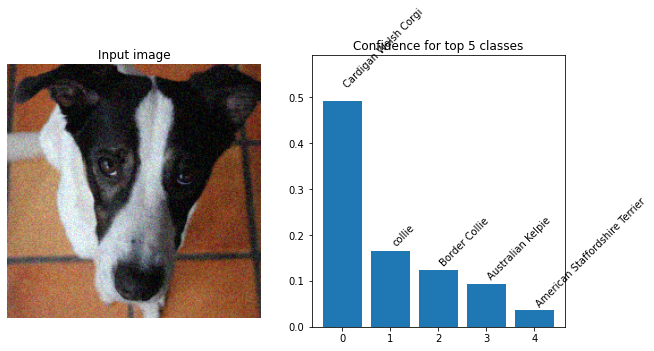

In [ ]:
plot_prediction(out, model(out))

Did not work very well, even after 30 * 1000 = 30000
queries. To get the benefits of both flexible adversarial attacks and efficient computation,
we need a better approach.

#### Simplifying our approach

In the previous approach, we seperated the gradient estimation and taking a step to optimize the perturbation. What if we combine the Monte Carlo search for the gradient together with the optimization i.e. we consider change the noise $\delta$ every time we do a blackbox query ("take a MC sample")?

Since we want a _descent_, we should only take a step (update $\delta$) every time we find a
random direction that goes downhill i.e. some direction $\eta \sim \mathcal{N}(0, \sigma)$ such that the loss increases:

$$J(\theta, \mathbf{x}+\delta+\eta, y) > J(\theta, \mathbf{x}+\delta, y),$$

in which case we update $\delta := \delta + \eta$. Since we sample the
direction from the gaussian distribution, a learning rate would be redundant
as we can control how much we update $\delta$ at each step with just hyperparameter $\sigma$.



In [ ]:
def black_box_iterated_descent(input, model, epsilon, target_label=None, sigma=0.1,
                    criterion=nn.CrossEntropyLoss(), lr=1e-3, queries=100):
  """
  Perturbs input with adverserial noise `delta`, where `delta` is found
  through greedy iterated descent. At each step, we change our current
  `delta` in a random direction, sampled from $Normal(0, \sigma)$. However,
  we only commit to this change if it causes the loss to increase. To determine
  this, we  query the blackbox `model` both before and after changing our `delta`.

  Arguments
  ---------
  input : PIL.Image
    input image of dimensions (224, 224)
  model : pytorch.nn.Module
    pytorch model that can be evaluated on input tensor in the dataset, and
    returns a tensor with shape [1, 1000] (imagenet classification)
  epsilon : float
    largest perturbation that can be applied to input image
  target_label (optional) : str
    A ImageNet class name. If provided, the probability of this class will be
    tracked during training, but no targeted attack will be performed. To do
    a targeted tack, the `criterion` must be changed accordingly.
  sigma : float
    Standard deviation to use when sampling the random direction used in GD
  criterion (optional): fun : tensor([1, 1000]) * tensor([1, 1]) -> tensor([1])
    A loss function which takes two arguments, the output of `model` and
    a label and returns the loss. Defaults to cross entropy loss if not
    provided.

  Returns
  ------
  PIL.Image
    The perturbed image after performing the blacb box attack as described.
  """
  assert input.size == (224, 224)
  
  # transformations
  to_tensor = transforms.ToTensor()
  to_pil = transforms.ToPILImage()

  input = to_tensor(copy.deepcopy(input)).to(dev)

  out = model(input)
  original_label, p = top_5_classes(out)[0]
  print(f"Unperturbed image classified as '{original_label}' with confidence p={p:.4}")
  original_label = class_name_to_id(original_label)
  if target_label is not None:
    target_label = class_name_to_id(target_label)

  label_tensor = torch.tensor(original_label).unsqueeze(0).to(dev)

  def forward(input, delta):
    return torch.clamp(input + torch.clamp(delta, -epsilon, epsilon), 0, 1)

  # used for later plot
  orig_probs = []
  targ_probs = []

  lr = torch.scalar_tensor(lr).to(dev)
  delta = torch.zeros_like(input).to(dev)
  with torch.no_grad():
    for i in range(queries):
      # loss with current delta
      out1 = model(forward(input,  delta))
      cur_loss = criterion(out1, label_tensor).detach()

      # loss with slight change to delta
      random_direction = torch.normal(mean=torch.zeros_like(delta).to(dev), std=torch.scalar_tensor(sigma).to(dev))
      out2 = model(forward(input, delta + random_direction))
      next_loss = criterion(out2, label_tensor).detach()

      # update delta if found better noise
      if next_loss > cur_loss:
        delta += random_direction

      # Print statistics
      if i % 50 == 0:
        print(f"Query {i + 1} / {queries}:")
        orig_prob = probability_of_class(out1, 'Border Collie')
        orig_probs.append(orig_prob)
        print(f"  Prob({class_id_to_name(original_label)}) = {orig_prob:.4}")
        if target_label is not None:
          target_prob = probability_of_class(out1, target_label)
          targ_probs.append(target_prob)
          print(f"  Prob({class_id_to_name(target_label)}) = {target_prob:.4}")
        print(f"  Noise norm: {torch.linalg.norm(torch.clamp(delta, -epsilon, epsilon)).item():.4}")
        print(f"  Max noise per pixel: {min(epsilon, torch.max(delta).item()):.4}")
        print(f"  Cur loss: {cur_loss}")

  new_image = forward(input, delta)
  if target_label is not None:
    return to_pil(new_image), orig_probs, targ_probs
  else:
    return to_pil(new_image), orig_probs

Unperturbed image classified as 'Border Collie' with confidence p=0.2645
Query 1 / 50:
  Prob(Border Collie) = 0.2645
  Noise norm: 3.883
  Max noise per pixel: 0.04706
  Cur loss: 1.32978093624115


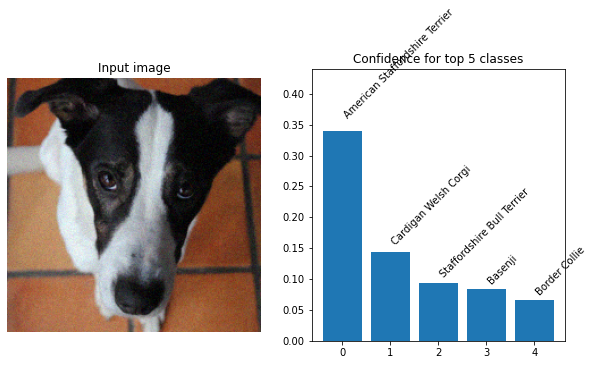

In [ ]:
out, _ = black_box_iterated_descent(blas_img, model, 0.2, sigma=0.01, queries=50)
plot_prediction(out, model(out))

_Just 50 queries is not always sufficient_

Unperturbed image classified as 'Border Collie' with confidence p=0.2645
Query 1 / 200:
  Prob(Border Collie) = 0.2645
  Noise norm: 1.164
  Max noise per pixel: 0.01204
  Cur loss: 1.32978093624115
Query 51 / 200:
  Prob(Border Collie) = 0.1096
  Noise norm: 4.78
  Max noise per pixel: 0.05856
  Cur loss: 2.2104783058166504
Query 101 / 200:
  Prob(Border Collie) = 0.0752
  Noise norm: 5.915
  Max noise per pixel: 0.07466
  Cur loss: 2.5875449180603027
Query 151 / 200:
  Prob(Border Collie) = 0.0592
  Noise norm: 6.569
  Max noise per pixel: 0.07972
  Cur loss: 2.8268346786499023


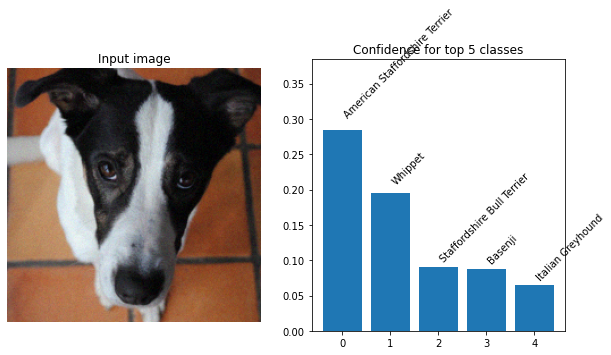

In [ ]:
out, _ = black_box_iterated_descent(blas_img, model, 0.2, sigma=0.003, queries=200)
plot_prediction(out, model(out))

This worked well. With just 200 queries, we were able to signfificantly
lower the confidence in `'Border Collie'` while barely adding any noise to the
image that the human eye can detect. Extrapolating the above result to other
images, we would be able to significantly reduce the model's top-5 accuracy.
However, we saw earlier that we could do better with FGSM with just 10 queries.
The benefits of this approach is the flexibility it allows, which we exploit
next...

This is a success by itself, but we still have 5 dog breeds in the top-5
classes, which does not _feel_ like a successful attack. We can try changing
the loss function used to try avoiding having any dogs in the top-5.

In [ ]:
def not_dog_loss(out, _):
  # penality for all dog predictions
  dog_ids = list(range(151, 276))
  p = softmax(out[0,:], dim=0)
  return 1 - sum([p[i] for i in dog_ids])

out1, probs = black_box_iterated_descent(blas_img, model, 0.2, sigma=0.002, queries=10000,
                                 criterion=not_dog_loss)

_Note: The output has been cleared because it's plotted later_

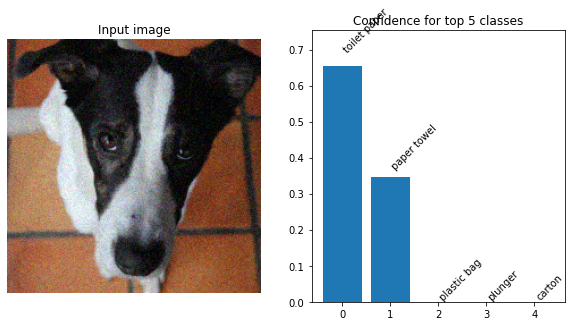

In [ ]:
plot_prediction(out1, model(out1))

Text(0, 0.5, 'Probability')

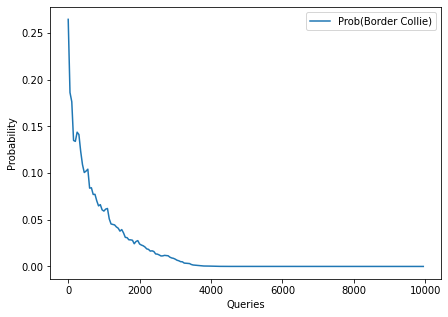

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(list(range(0, len(probs) * 50, 50)), probs, label="Prob(Border Collie)")
ax.legend()
ax.set_xlabel("Queries")
ax.set_ylabel("Probability")

I initially tried making the loss function a weighted sum
of the cross entrop loss for predicting all the different dog breeds, but that caused the adversary to add noise such
that it predicted a particular dog breed with above 80%
confidence, which is not what we want. I therefore moved onto maximising the probability mass outside dog breeds.

Doing 10000 queries might be a bit to excessive, as the probability of not classifying the input as a dog was already below 1% after about 3000 queries. However, this
shows that we are able to perform arbitrarily "flexible" attacks (low confidence in whatever subset of classes we want, while structured noise is minimally human visable)  without having access to the gradients.

#### Targeted black box attacks

Now that we have our `black_box_iterated_descent` algorithm set up, we can change the loss function to allow us to do a _targeted_ attack. As an example,
I force the image of Blas to be classified as a Sea Slug. However, any label
could be used.

In [ ]:
sea_slug_label = class_name_to_id('sea slug')
def sea_slug_loss2(out, label):
  p = softmax(out[0,:], dim=0)
  return p[sea_slug_label]

out, prob1, prob2 = black_box_iterated_descent(blas_img, model, 0.2, sigma=0.002, queries=20000,
                                 criterion=sea_slug_loss2, target_label='sea slug')
# plot_prediction(out, model(out))

Unperturbed image classified as 'Border Collie' with confidence p=0.2645
Query 1 / 20000:
  Prob(Border Collie) = 0.2645
  Prob(sea slug) = 7.035e-07
  Noise norm: 0.7776
  Max noise per pixel: 0.00896
  Cur loss: 7.034660143290239e-07
Query 51 / 20000:
  Prob(Border Collie) = 0.1689
  Prob(sea slug) = 2.306e-06
  Noise norm: 3.803
  Max noise per pixel: 0.04178
  Cur loss: 2.3062591480993433e-06
Query 101 / 20000:
  Prob(Border Collie) = 0.1747
  Prob(sea slug) = 3.399e-06
  Noise norm: 4.319
  Max noise per pixel: 0.05009
  Cur loss: 3.3986414109676844e-06
Query 151 / 20000:
  Prob(Border Collie) = 0.164
  Prob(sea slug) = 4.686e-06
  Noise norm: 5.025
  Max noise per pixel: 0.06648
  Cur loss: 4.685926342062885e-06
Query 201 / 20000:
  Prob(Border Collie) = 0.1721
  Prob(sea slug) = 5.368e-06
  Noise norm: 5.429
  Max noise per pixel: 0.0665
  Cur loss: 5.3675571507483255e-06
Query 251 / 20000:
  Prob(Border Collie) = 0.162
  Prob(sea slug) = 6.297e-06
  Noise norm: 5.704
  Max nois

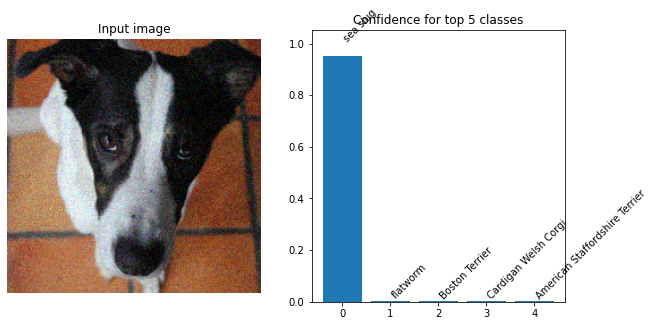

In [ ]:
plot_prediction(out, model(out))

Text(0, 0.5, 'Probability')

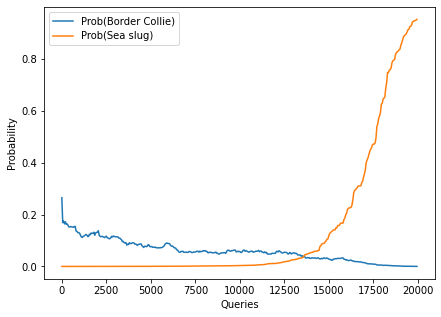

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
# we "track" the current probability once every batchsize, where batchsize=50
ax.plot(list(range(0, len(prob1) * 50, 50)), prob1, label="Prob(Border Collie)")
ax.plot(list(range(0, len(prob2) * 50, 50)), prob2, label="Prob(Sea slug)")
ax.legend()
ax.set_xlabel("Queries")
ax.set_ylabel("Probability")

We were able to successfully perform a targeted black box
attack while adding minimal perturbations to the original
image, as we see in the Blas image above. However, this
took a lot of queries to achieve, as the probability of
sea slug didn't start increasing by much until we reached around 13000 queries.

### Same noise on different images

We now move onto the task:

> Load another image. Does the adversarial noise generated for one image work to fool the network when added to a different image (~5 marks for for non-minimal investigation and good writeup)


To learn the most from this, we should do a more structured approach than finding
another arbitrary image and transfering the noise to it. It would be nice to have
a lot of images that fit within the 1000 Resnet classes, such that we can can
perform quantitative experiments like  adding the same noise to 
100  other Border Collie images, or to 1000 random mages from
the whole ImageNet dataset.

With this in mind, my investigation is structured as follows: I first set
up a `Dataset` with both images and labels from a small subset of the
ImageNet dataset. I then extract the noise I got from doing a FGSM attack on
the Blas image, as well  as the noise from the gradient descent approach, and
transfer this to a random selection of other images, measuring the effect
on resnet's performance. After this, I move onto investigating:

> Can we find a universal noise tensor $\eta$ that significantly worsens resnet's performance when applied to any image $\mathbf{x}$?

After this, I build upon my answer to this question to create a method that
finds a universal noise vector $\eta$ that can deliberately target a specific
class regardless of which image $\mathbf{x}$ it is applied to.

#### Setting up mini-ImageNet


Sadly, the ImageNet dataset is no longer publically available due to stress
on the [ImageNet website](https://www.image-net.org/update-mar-11-2021.php).
Subsets of the dataset are available on [Kaggle](..) and elsewhere, and
can be freely used for [education purposes](https://www.image-net.org/download)
according to the terms of access, which is what I am doing.

I found some alternative download links to subsets of it in [this stackoverflow thread](https://stackoverflow.com/questions/55762107/downloading-data-from-imagenet), which
I downloaded and uploaded to my own google drive. These images are solely used for the educational purposes of doing my DNN assignment, so I believe their usage is ina ccordance with ImageNet's terms of use. Specifically, I downloaded
the images linked from [this github issue](https://github.com/dragen1860/LearningToCompare-Pytorch/issues/4) and found matching labels in [this repo](https://github.com/twitter-research/meta-learning-lstm/tree/master/data/miniImagenet)
(because the first zip file did not contain any labels folder).
If you want to rerun the code in this section, please download the dataset yourself and change the code below accordingly. The final file structure after running the below cells should be:

     /content/mini-imagenet/
     |  labels/
     |  | test.csv
     |  | train.csv
     |  | val.csv
     |  images/
     |  | n0185567200000003.jpg
     |  | ...

 To manage the data, I create a `DataSet` class which can nicely be wrapped
 in a torch `DataLoader`.

In [ ]:
from google.colab import drive
import zipfile

# prompts for authorization
drive.mount('/content/drive')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/datasets/labels.zip")
zip_ref.extractall("/content/mini-imagenet/labels/")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/datasets/mini-imagenet.zip", 'r')
zip_ref.extractall("/content/mini-imagenet/") # the zip file contains a folder called "images/"
zip_ref.close()

Mounted at /content/drive


In [ ]:
from typing import Any
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import glob
import pandas as pd
import io

class CustomDataset(Dataset):

  def __init__(self, path: Path, split : str, frac : float = None):
    """
    Attributes
    -------------
    path : Path
      A Path object pointing to the root of the data
    split : str
      A string. Must be one of "val", "test" and "train"
    frac : float
      A value between 0.0 and 1.0. If specified, only this fraction of the found
      data will be used to create the dataset, and the dataset is shuffled before
      doing so.
    """
    assert path.exists()

    # save for __getitem__ later
    self.path = path
    
    # create the csv of all of our files, ignoring already set up eval,val,train split
    csv_files = list(glob.glob(str(path / f"labels/{split}.csv")))
    # csv_files = list(glob.glob(str(path / "labels/*.csv")))
    data_df = pd.concat([pd.read_csv(f) for f in csv_files])

    # Figure out the mappings from the confusing "n01855672"-like labels
    imagenet_label_map_url = "https://raw.githubusercontent.com/mf1024/ImageNet-Datasets-Downloader/master/classes_in_imagenet.csv"
    response = requests.get(imagenet_label_map_url)
    class_names_df = pd.read_csv(io.StringIO(response.content.decode('utf-8'))).set_index('synid')

    # add label column to original dataframe, which previously had "n\d+" labels
    data_df['class_label'] = data_df.apply(lambda x : class_names_df.loc[x[1]][0], axis=1)

    # then also map to IDs
    imagenet_label_map_url = "https://raw.githubusercontent.com/akshaychawla/ImageNet-downloader/master/imagenet_class_index.json"
    response = requests.get(imagenet_label_map_url)
    class_ids = json.loads(response.text)
    # map from label to ID instead
    self.class_id = {}
    for k in class_ids.keys():
      self.class_id[class_ids[k][0]] = int(k)
    
    # save for later
    if frac is None:
      self.df = data_df
    else:
      # shuffle the dataset of a fraction is used
      self.df = data_df.sample(frac=frac).reset_index(drop=True)

    # transform function
    self.to_tensor = transforms.ToTensor()

  def __len__(self) -> int:
    # can do len(dataset)
    return self.df.shape[0]

  def __getitem__(self, index: int) -> Any:
    row = self.df.iloc[index]
    # use pillow to load the images, like we did for Blas, then crop and centre
    image = input_transform(Image.open(self.path / f"images/{row['filename']}"))
    # we created meaningful labels in __init__, so use these
    class_label = str(row['label'])
    # convert to tensors
    return self.to_tensor(image), torch.tensor(self.class_id[class_label])

  def get_dataframe(self):
    return self.df

def get_dataset(split, frac=None):
  assert split in ["train", "val", "test"]
  return CustomDataset(Path("/content/mini-imagenet/"), split, frac)

data = get_dataset("val")
print(f"Validation dataset has {len(data)} items")
data.get_dataframe().head()

Validation dataset has 9600 items


filename      label class_label
0  n0185567200000003.jpg  n01855672       goose
1  n0185567200000004.jpg  n01855672       goose
2  n0185567200000010.jpg  n01855672       goose
3  n0185567200000013.jpg  n01855672       goose
4  n0185567200000016.jpg  n01855672       goose

In [ ]:
# to demonstrate shuffling
get_dataset("train", 0.01).get_dataframe().head()

filename      label  class_label
0  n0774760700001071.jpg  n07747607       orange
1  n0429656200000348.jpg  n04296562        stage
2  n0427554800000840.jpg  n04275548   spider web
3  n0443565300000191.jpg  n04435653    tile roof
4  n0334703700000026.jpg  n03347037  fire screen

Let's do a simple check on how well ResNet50 is doing out of the box, using
our ImageNet training dataset.

In [ ]:
def evaluate_model(model, data, noise=None, criterion=nn.CrossEntropyLoss(reduction='sum'),
                   batchsize=50, stop_after=100000, model_name=None, target_label=None):
  """
  Evaluates the model's performance in terms of loss, top-1 accuracy and top-5 accuracy
  on images from the data, adding the same `noise` to all the images if
  it is specified.

  Attributes:
  -----------------
  model : nn.Module
    The imagenet-trained module. Should be of shape:
    tensor([x, 3, 224, 224]) -> tensor([x, 1000])
  data : Dataset
    The data to evaluate on
  stop_after : int
    Only does this many batches before stopping the evaluation. Used to limit computation time.
  model_name : str
    If specified, the returned dataframe has an index with the model name in it
  target_label : str
    If specified, evaluation is done in terms of how successfully the specified
    noise can perturb the classification to predict `target_label`
  noise : tensor([3, 224, 224])
    Noise to be applied to each of the input images in `data`
  criterion : fun : tensor([x, 1000]) , tensor([x, 1]) -> tensor([1])
    Loss function to base evaluation on
  """
  with torch.no_grad():
    cumulative_loss = torch.zeros([1]).to(dev)
    correct_top1s = 0
    correct_top5s = 0

    # temporaily put model in GPU
    model = model.to(dev)

    if target_label is not None:
      target_label = torch.scalar_tensor(class_name_to_id(target_label)).type(torch.LongTensor).to(dev)

    # repeat the noise, once for each image in the batch
    if noise is not None:
      noise = noise.unsqueeze(0).repeat(batchsize, 1, 1, 1)
      noise = noise.to(dev)

    dataloader = DataLoader(data, batch_size=batchsize, shuffle=True, drop_last=True)
    for i, (imgs, labels) in enumerate(dataloader):
      torch.cuda.empty_cache()
      # move to GPU if we use one
      imgs = imgs.to(dev)
      labels = labels.to(dev)

      if noise is not None:
        imgs = torch.clamp(imgs + noise, 0 , 1)
  
      # make prediction
      out = model(imgs).detach()
      p = softmax(out, dim=1)
      _, predict_labels = p.topk(5)
  
      # iterate our batch and count correct predictions
      for lab, pred in zip(labels, predict_labels):
        # We are doing a targeted attack, so evaluate based on how successful that is
        if target_label is not None:
          lab = target_label
        # top-5
        if lab in pred:
          correct_top5s += 1
        # top-1
        if lab == pred[0]:
          correct_top1s += 1
      # accumlate loss
      cumulative_loss += criterion(out, labels)
  
      if i == stop_after - 1:
        break
  
    # aggregate
    num_datapoints = min(batchsize * stop_after, len(data))
    cumulative_loss /= num_datapoints
    correct_top1s /= num_datapoints
    correct_top5s /= num_datapoints

    # make sure model is removed from GPU memory
    # model = model.cpu()
    
    # format result in nice dataframe
    row_entries = [cumulative_loss.item(), correct_top1s, correct_top5s]
    column_names = ["Loss", "Top-1 Accuracy", "Top-5 Accuracy"]
    # we are evaluating how often we can get the target label in top 1/5
    if target_label is not None:
      column_names = ["Loss", "Top-1 Success rate", "Top-5 Success rate"]
    if model_name is not None:
      return pd.DataFrame([[model_name] + row_entries], columns = ["Model"] + column_names).set_index('Model')
    else:
      return pd.DataFrame([row_entries], columns = column_names)

In [ ]:
torch.cuda.empty_cache()
# min(50 * 100, 9600) data images tested on
unperturbed_eval = evaluate_model(model, data, batchsize=50, stop_after=100)
unperturbed_eval

Loss  Top-1 Accuracy  Top-5 Accuracy
0  0.495696           0.861          0.9764

As expected, resnet50 performs well on ImageNet data. We also emphasize
that I cannot tell if the data in whatever `val` split I downloaded from the
Internet were also in the validation split used to train Resnet50. Therefore,
it may be that some the images were actually in the `train` split used to
train resnet. This might explain the high classification accuracy.

Now, let's extract the noise from FGSM and the gradient descent approach.
We also quickly plot the perturbed images to recall how the noise looks like.


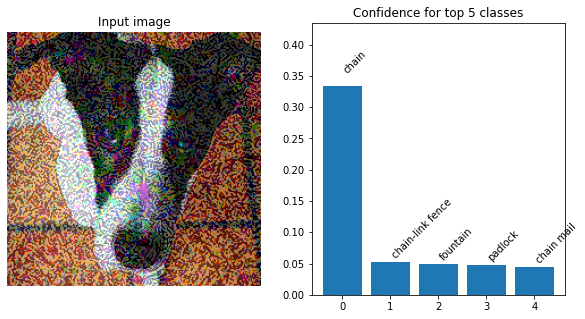

In [ ]:
perturbed_blas, fgsm_perturbation = fgsm_perturb_image(blas_img, 'Border Collie', model, epsilon=0.2, get_delta=True)
plot_prediction(perturbed_blas, model(perturbed_blas))

Unperturbed image classified as 'Border Collie' with confidence p=0.2645
Epoch 1 / 20:
  Prob(Border Collie) = 0.001695
  Prob(Border Collie) = 0.001695
  Noise norm: 0.388
  Max noise per pixel: 0.001
Epoch 2 / 20:
  Prob(Border Collie) = 8.632e-06
  Prob(Border Collie) = 8.632e-06
  Noise norm: 0.6164
  Max noise per pixel: 0.002001
Epoch 3 / 20:
  Prob(Border Collie) = 5.092e-08
  Prob(Border Collie) = 5.092e-08
  Noise norm: 0.8157
  Max noise per pixel: 0.003005
Epoch 4 / 20:
  Prob(Border Collie) = 4.698e-10
  Prob(Border Collie) = 4.698e-10
  Noise norm: 1.004
  Max noise per pixel: 0.004011
Epoch 5 / 20:
  Prob(Border Collie) = 6.197e-12
  Prob(Border Collie) = 6.197e-12
  Noise norm: 1.182
  Max noise per pixel: 0.005021
Epoch 6 / 20:
  Prob(Border Collie) = 1.43e-13
  Prob(Border Collie) = 1.43e-13
  Noise norm: 1.35
  Max noise per pixel: 0.006035
Epoch 7 / 20:
  Prob(Border Collie) = 3.992e-15
  Prob(Border Collie) = 3.992e-15
  Noise norm: 1.509
  Max noise per pixel: 0.00

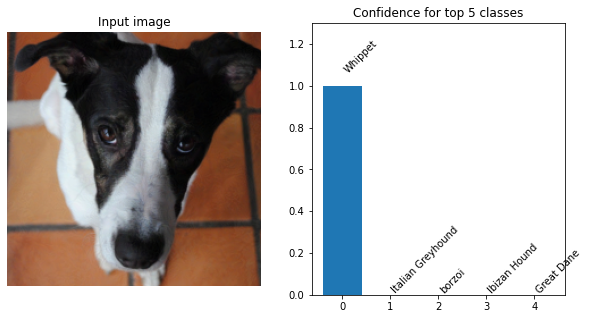

In [ ]:
perturbed_blas, gd_perturbation = gradient_descent_attack(blas_img, 'Border Collie', model, 0.01, get_delta=True)
plot_prediction(perturbed_blas, model(perturbed_blas))

We then add the two kinds of noise to some random subset of ImageNet data
and look at the accuracy.

In [ ]:
gd_eval = evaluate_model(model, data, batchsize=50, stop_after=100, noise=gd_perturbation)
fgsm_eval = evaluate_model(model, data, batchsize=50, stop_after=100, noise=fgsm_perturbation)

In [ ]:
pd.concat([unperturbed_eval, fgsm_eval, gd_eval], ignore_index=True).rename(
    index= {0 : "No perturbation",
            1 : "FGSM perturbation",
            2 : "GD perturbation"}
)

Loss  Top-1 Accuracy  Top-5 Accuracy
No perturbation    0.495696          0.8610          0.9764
FGSM perturbation  6.639458          0.0694          0.1626
GD perturbation    0.526894          0.8562          0.9732

_Table: Resnet50's accuracy on random selection of ImageNet data when_
_adding either no perturbation or the perturbation found by targeting a image_
_of Blas_

We notice that the noise found with FGSM was a lot more effective in decreasing
the classification accuracy compared to the gradient descent approach.
One hypothesis is  that in the FGSM case, we had a very high epsilon, causing a large norm in the noise vector, but for our gradient descent
algorithm, despite setting a high epsilon, we add a noise vector with
low magnitude since the epsilon only sets an upper limit. However, this cannot
fully explain the results because we saw in [Performing a simple attack with FGSM](###Performing-a-simple-attack-with-FGSM) that adding fully random noise 
with  the same norm as FGSM was not as effective. The results might therefore
be a combination of GD using a low norm noise vector as well as heavily
targeting a specific image by iteratively only making very small changes to
cause the prediction of a particular image to go horribly wrong. Intuitively,
this would not generalize well to other images.

If we want to learn some "unversal noise" with low magnitude
that generalises across the ImageNet dataset, we could try
to set up a new optimization problem that can be solved with gradient descent.
We do this next.

#### Finding universal structed noise with gradient descent

_Despite FGSM noise generalizing well, it produced a lot of artifacts. The_
_motivation for the approach to come is thus less noticeable (to the human eye)_
_structured noise, as well as more flexibility. Implementing this is also a necessary stepping stone for_
_doing universal targeted attacks._

We recall the optimization problem used when developing `gradient_descent_attack`:

$$ \underset{\mathbf{\eta}}{\mathrm{argmin}} \;
- J(\theta, \mathbf{x}+\mathbf{\eta},\textrm{original label}).
$$

If we let $\mathbf{X}$ be some minibatch of training data with tuples $(\mathbf{x},l)$,
where $\mathbf{x}$ is an image and $l$ is the corresponding correct label,
we can generalize the above "cost" to:

$$ \underset{\mathbf{\eta}}{\mathrm{argmin}} \;
- \frac{1}{n} \sum_{(\mathbf{x},l) \in \mathbf{X}} J(\theta, \mathbf{x}+\mathbf{\eta},l).
$$

i.e. we want to find some unviversal noise $\eta$ that increases resnet's cost
as much as possible when evaluating it on a _batch_ of different images.
Below, I implement a supervised learner with such a cost function (with
`CrossEntropyLoss` handling the averaging, so it might be slightly different).
I also use `ignite` components to do this, taking inspiration from the sample
code in B.2.



In [ ]:
# only use 5% and 2% of the data
train_ds = get_dataset("train", 0.05)
val_ds = get_dataset("val", 0.02)

In [ ]:
from ignite.utils import convert_tensor
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

def fit_universal_asversary(resnet, training_dataset, test_dataset, enable_logging=True,
              lr=0.001, batchsize=30, epochs=5, epsilon=0.2, criterion=None):
  '''Fits an AdversaryModule, that contains a perturbation tensor as its parameters,
     such that the loss function `criterion` is minimized when evaluated on resnet50's
     predictions on different images perturbed by the same AdversaryModule. Specifically,
     the following optimization is done:

         find perturbation eta that minimizes criterion(resnet(x + eta), label)

    for image-label pairs (x, label) from the `training_dataset`. criterion defaults
    to the negation of the cross entropy loss, such that this is maximised.

  Arguments
  ---------
  resnet : pytorch.nn.Module
    A pretrained ImageNet model
  training_dataset : pytorch.util.data.Dataset
    used to train the model
  test_dataset : pytorch.util.data.Dataset
    used to evaluate the performance of the model at the end of each epoch
  enable_logging : bool
    whether to print progress to console
  lr : float
    the learning rate used to train the AdversaryModule
  batchsize : int
    batchsize to use during training
  epochs : int
    number of epochs to train for
  epsilon : float
    maximum perturbation allowed per pixel per channel. (The colours are real
    numbers between 0 and 1)
  criterion : the loss function (optional)
    See earlier in doc string

  Retuns
  ------
  pytorch.nn.Module
    the adversary after training
  '''

  train_loader = DataLoader(
      training_dataset,
      batch_size=batchsize,
      shuffle=True,
      drop_last=True
  )

  # The tensor is just used to figure out the shape of the images
  blas_tensor = to_tensor(copy.deepcopy(blas_img)).to(dev)
  adversary = AdversaryModule(blas_tensor, epsilon).to(dev)

  optimizer = torch.optim.Adam(adversary.parameters(), lr=lr)

  # move the model to GPU memory
  resnet = resnet.to(dev)

  # we want to increase Resnet's loss with the perturbations, so negate so
  #   that Adam maximise it
  crit = nn.CrossEntropyLoss().to(dev)
  def default_criterion(resnet_out, label):
    return -crit(resnet_out, label)
  if criterion is None:
    criterion = default_criterion

  def loss_function(adversary_out, label):
    # label = label.type(torch.LongTensor).to(dev)
    return criterion(resnet(adversary_out), label)

  trainer = create_supervised_trainer(adversary, optimizer, loss_function, device=dev)

  @trainer.on(Events.ITERATION_COMPLETED(every=10))
  def log_training_loss(trainer):
    if enable_logging:
      print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.2f}")

  @trainer.on(Events.STARTED)
  @trainer.on(Events.EPOCH_COMPLETED)
  def log_training_results(trainer):
    if enable_logging:
      perturbation = adversary.get_noise()
      df = evaluate_model(resnet, test_dataset, perturbation, stop_after=8, batchsize=50)
      print(f"Training Results - Epoch: {trainer.state.epoch} Validation loss: " \
        f"{df.iloc[0].values[0]} Top-1 Acc: {df.iloc[0].values[1]} Top-5 Acc: {df.iloc[0].values[2]}")

  # start the trainer
  trainer.run(train_loader, max_epochs=epochs)

  return adversary

In [ ]:
adversary = fit_universal_asversary(model, train_ds, val_ds, lr=0.001, epochs=10)

Epoch[1] Loss: -0.59
Epoch[1] Loss: -0.68
Epoch[1] Loss: -0.46
Epoch[1] Loss: -0.27
Epoch[1] Loss: -0.30
Epoch[1] Loss: -0.39
Training Results - Epoch: 1 Validation loss: 0.5331195592880249 Top-1 Acc: 0.8475 Top-5 Acc: 0.9725
Epoch[2] Loss: -1.21
Epoch[2] Loss: -1.00
Epoch[2] Loss: -0.64
Epoch[2] Loss: -1.19
Epoch[2] Loss: -0.95
Epoch[2] Loss: -0.85
Training Results - Epoch: 2 Validation loss: 0.8902679085731506 Top-1 Acc: 0.79 Top-5 Acc: 0.93
Epoch[3] Loss: -0.85
Epoch[3] Loss: -1.45
Epoch[3] Loss: -1.05
Epoch[3] Loss: -1.46
Epoch[3] Loss: -1.94
Epoch[3] Loss: -2.14
Epoch[3] Loss: -4.16
Training Results - Epoch: 3 Validation loss: 4.12221097946167 Top-1 Acc: 0.3625 Top-5 Acc: 0.61
Epoch[4] Loss: -4.79
Epoch[4] Loss: -8.40
Epoch[4] Loss: -11.68
Epoch[4] Loss: -11.27
Epoch[4] Loss: -12.23
Epoch[4] Loss: -15.56
Training Results - Epoch: 4 Validation loss: 20.75924301147461 Top-1 Acc: 0.02 Top-5 Acc: 0.125
Epoch[5] Loss: -16.45
Epoch[5] Loss: -21.33
Epoch[5] Loss: -25.62
Epoch[5] Loss: -2

We can then extract the noise and do a quantitative measurement on how much it
worsens Resnet50's performance.

In [ ]:
perturbation = adversary.get_noise()
evaluate_model(model, val_ds, perturbation)

Loss  Top-1 Accuracy  Top-5 Accuracy
0  85.794022             0.0        0.052083

We note that we use $𝛜=0.20$, the
same as what was used in FGSM. The drop
in accuracy and incrase in loss is also
a lot higher than what we saw when we applied the FGSM noise.
This approach therefore is more suitable for doing universal
adversarial attacks. Next, we test the noise found on a few
example images.

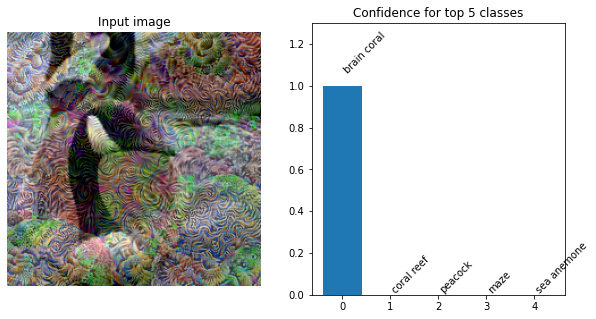

In [ ]:
img, _ = data.__getitem__(42)
perturbed_img = adversary.forward(img.to(dev))
plot_prediction(to_pil(perturbed_img), model(perturbed_img))

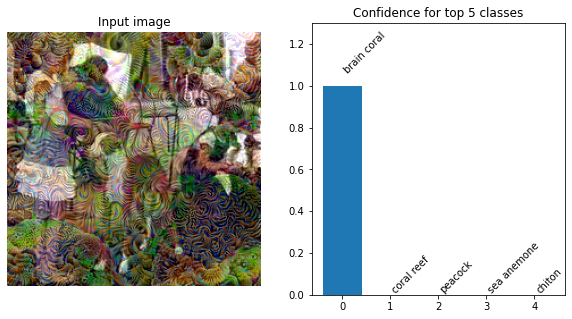

In [ ]:
img, _ = data.__getitem__(600)
perturbed_img = adversary.forward(img.to(dev))
plot_prediction(to_pil(perturbed_img), model(perturbed_img))

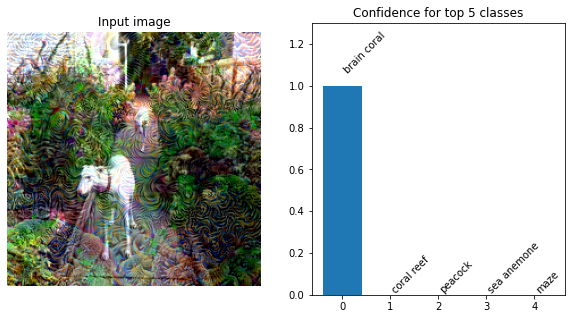

In [ ]:
img, _ = data.__getitem__(1000)
perturbed_img = adversary.forward(img.to(dev))
plot_prediction(to_pil(perturbed_img), model(perturbed_img))

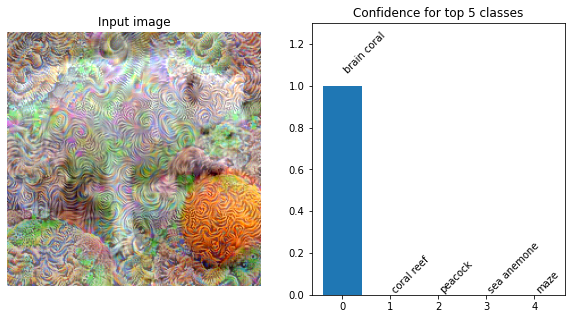

In [ ]:
img, _ = data.__getitem__(1200)
perturbed_img = adversary.forward(img.to(dev))
plot_prediction(to_pil(perturbed_img), model(perturbed_img))

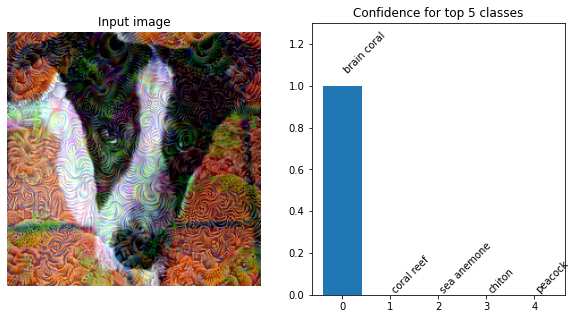

In [ ]:
perturbed_img = adversary.forward(to_tensor(blas_img).to(dev))
plot_prediction(to_pil(perturbed_img), model(perturbed_img))

We recall our loss function

```
-criterion(resnet(adversary_out), label)
```

where we only told our adversary to maximise the loss of Resnet's predictions,
not ever specifying a targeted class. However, it seems to have done a targeted attack on `Brain Coral` all by itself, which is fairly interesting. One
explanation for this is our cross entropy loss function, which gives higher values the more "incorrect" the predictions are. If we say with near 0%
confidence that the actual label is correct, the loss becomes high and the easiest
way to achieve this is to increase the confidence for some arbitrary label to nearly 100%.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Brain_coral.jpg/451px-Brain_coral.jpg" alt="brain" width="150"/> _Brain coral (from Wikipedia commons)_

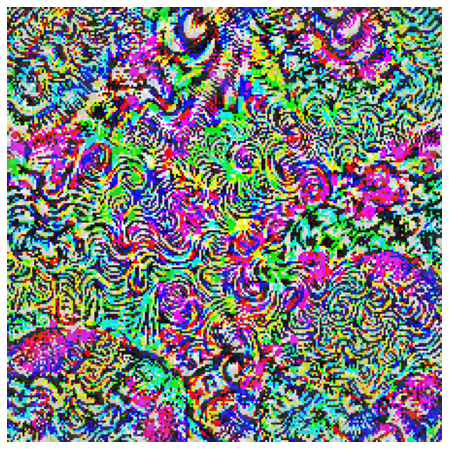

In [ ]:
_, ax = plt.subplots(figsize=(8,8))
ax.imshow(to_pil(perturbation))
ax.axis('off')
plt.show()

_Figure: The universal perturbation found_

If we look at the above input images or at the perturbation in isolation,
we clearly see that there is a lot more macroscopic structure to the noise
compared with e.g. the FGSM noise. There are circular patterns which somewhat
resembles the "wrinkles" on the brain coral image above, but this observation
might just be placebo.

#### Performing targeted universal attacks

Seeing as the above approach gave a targeted attack without us guiding it towards a target, it should fully be possible to create targeted universeral
noise as well. We change our loss function slightly and rerun our optimization
algorithm such that we target the class 'sea slug'. We also use the same
default epsilon as above, $ϵ = 0.20$.

In [ ]:
crit = nn.CrossEntropyLoss()
sea_slug_label = torch.scalar_tensor(class_name_to_id('sea slug')).type(torch.LongTensor)#.to(dev)
def target_criterion(resnet_out, label):
  # want to minimize loss of classifying as a Sea Slug
  return crit(resnet_out, torch.ones_like(label).to(dev) * sea_slug_label.to(dev))

targeted_adversary = fit_universal_asversary(model, train_ds, val_ds, lr=0.001,
                                             epochs=10, criterion=target_criterion)

Training Results - Epoch: 0 Validation loss: 0.3839045763015747 Top-1 Acc: 0.6927083333333334 Top-5 Acc: 0.7552083333333334
Epoch[1] Loss: 17.86
Epoch[1] Loss: 18.26
Epoch[1] Loss: 18.04
Epoch[1] Loss: 19.28
Epoch[1] Loss: 17.42
Epoch[1] Loss: 15.55
Training Results - Epoch: 1 Validation loss: 0.5251116752624512 Top-1 Acc: 0.6510416666666666 Top-5 Acc: 0.7552083333333334
Epoch[2] Loss: 14.31
Epoch[2] Loss: 15.61
Epoch[2] Loss: 13.19
Epoch[2] Loss: 12.60
Epoch[2] Loss: 12.98
Epoch[2] Loss: 10.54
Training Results - Epoch: 2 Validation loss: 1.722548246383667 Top-1 Acc: 0.4427083333333333 Top-5 Acc: 0.5989583333333334
Epoch[3] Loss: 6.90
Epoch[3] Loss: 6.24
Epoch[3] Loss: 6.27
Epoch[3] Loss: 5.57
Epoch[3] Loss: 4.22
Epoch[3] Loss: 3.32
Epoch[3] Loss: 2.03
Training Results - Epoch: 3 Validation loss: 5.552702903747559 Top-1 Acc: 0.15104166666666666 Top-5 Acc: 0.3229166666666667
Epoch[4] Loss: 3.34
Epoch[4] Loss: 2.48
Epoch[4] Loss: 3.27
Epoch[4] Loss: 2.93
Epoch[4] Loss: 2.00
Epoch[4] Loss

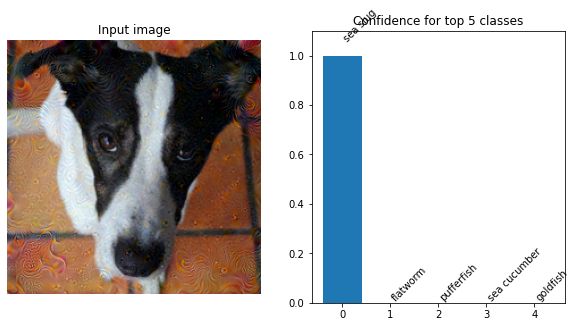

In [ ]:
perturbed_img = targeted_adversary.forward(to_tensor(blas_img).to(dev))
plot_prediction(to_pil(perturbed_img), model(perturbed_img.to(dev)))

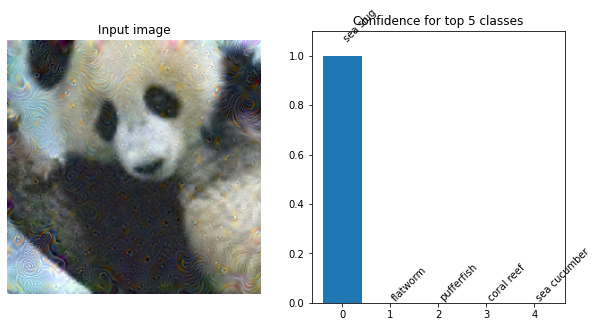

In [ ]:
perturbed_img = targeted_adversary.forward(to_tensor(panda_img).to(dev))
plot_prediction(to_pil(perturbed_img), model(perturbed_img.to(dev)))

In [ ]:
targeted_attack_test_data = get_dataset('test')
print(f"We have {len(targeted_attack_test_data)} test images.")
# extract the structured noise
perturbation = targeted_adversary.get_noise()
evaluate_model(model, targeted_attack_test_data, perturbation, model_name='Resnet50',
               target_label='sea slug')

We have 12000 test images.


Loss  Top-1 Success rate  Top-5 Success rate
Model                                                      
Resnet50  15.683664            0.915417            0.958417

Compared to the earlier universal gradient descent attacks, the noise is 
a lot less visible (maybe specifying a target helped?), but we can still clearly see adversarial artifacts.
I am not sure why the perturbation is less visible now. Regardless,
we are still able to misguide the network to predict sea slug for over 90%
of our 12k images. We could also try reducing our epsilon to 1%, only allowing
pixel value changes of $\frac{255}{100} < 3$.

In [ ]:
targeted_adversary = fit_universal_asversary(model, train_ds, val_ds, lr=0.001,
                                             epochs=10, criterion=target_criterion,
                                             epsilon=0.01)

Training Results - Epoch: 0 Validation loss: 0.4476773142814636 Top-1 Acc: 0.671875 Top-5 Acc: 0.7552083333333334
Epoch[1] Loss: 17.69
Epoch[1] Loss: 19.36
Epoch[1] Loss: 18.44
Epoch[1] Loss: 19.92
Epoch[1] Loss: 19.19
Epoch[1] Loss: 17.87
Training Results - Epoch: 1 Validation loss: 0.5140663385391235 Top-1 Acc: 0.6614583333333334 Top-5 Acc: 0.75
Epoch[2] Loss: 19.22
Epoch[2] Loss: 16.33
Epoch[2] Loss: 18.12
Epoch[2] Loss: 16.49
Epoch[2] Loss: 16.77
Epoch[2] Loss: 19.18
Training Results - Epoch: 2 Validation loss: 0.4704054594039917 Top-1 Acc: 0.6458333333333334 Top-5 Acc: 0.7447916666666666
Epoch[3] Loss: 15.34
Epoch[3] Loss: 15.95
Epoch[3] Loss: 15.80
Epoch[3] Loss: 18.83
Epoch[3] Loss: 17.04
Epoch[3] Loss: 14.71
Epoch[3] Loss: 16.29
Training Results - Epoch: 3 Validation loss: 0.47030168771743774 Top-1 Acc: 0.65625 Top-5 Acc: 0.7447916666666666
Epoch[4] Loss: 15.74
Epoch[4] Loss: 16.35
Epoch[4] Loss: 15.85
Epoch[4] Loss: 15.24
Epoch[4] Loss: 16.33
Epoch[4] Loss: 15.49
Training Resu

In [ ]:
perturbation = targeted_adversary.get_noise()
evaluate_model(model, targeted_attack_test_data, perturbation, model_name='Resnet50', target_label='sea slug')

Loss  Top-1 Success rate  Top-5 Success rate
Model                                                     
Resnet50  0.541321             0.00075             0.00725

Setting $\epsilon$ to as low as 1%, we did not have
much success in misguiding our Resnet model.
We can try a slightly higher $\epsilon =0.07$:

In [ ]:
targeted_adversary = fit_universal_asversary(model, train_ds, val_ds, lr=0.001,
                                             epochs=10, criterion=target_criterion,
                                             epsilon=0.07)

Training Results - Epoch: 0 Validation loss: 0.45828089118003845 Top-1 Acc: 0.6770833333333334 Top-5 Acc: 0.7552083333333334
Epoch[1] Loss: 17.39
Epoch[1] Loss: 17.95
Epoch[1] Loss: 18.13
Epoch[1] Loss: 16.89
Epoch[1] Loss: 18.75
Epoch[1] Loss: 16.27
Training Results - Epoch: 1 Validation loss: 0.49836379289627075 Top-1 Acc: 0.6510416666666666 Top-5 Acc: 0.75
Epoch[2] Loss: 14.00
Epoch[2] Loss: 14.54
Epoch[2] Loss: 13.92
Epoch[2] Loss: 9.92
Epoch[2] Loss: 12.26
Epoch[2] Loss: 9.50
Training Results - Epoch: 2 Validation loss: 2.2747278213500977 Top-1 Acc: 0.3802083333333333 Top-5 Acc: 0.5677083333333334
Epoch[3] Loss: 7.65
Epoch[3] Loss: 4.51
Epoch[3] Loss: 6.26
Epoch[3] Loss: 6.18
Epoch[3] Loss: 4.17
Epoch[3] Loss: 4.12
Epoch[3] Loss: 5.48
Training Results - Epoch: 3 Validation loss: 5.378589153289795 Top-1 Acc: 0.16145833333333334 Top-5 Acc: 0.3333333333333333
Epoch[4] Loss: 4.72
Epoch[4] Loss: 4.00
Epoch[4] Loss: 2.47
Epoch[4] Loss: 3.87
Epoch[4] Loss: 3.38
Epoch[4] Loss: 4.10
Traini

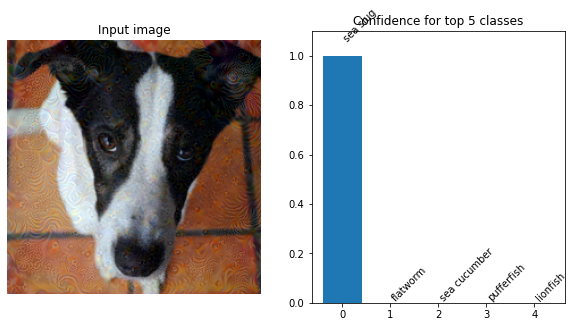

In [ ]:
perturbed_img = targeted_adversary.forward(to_tensor(blas_img).to(dev))
plot_prediction(to_pil(perturbed_img), model(perturbed_img.to(dev)))

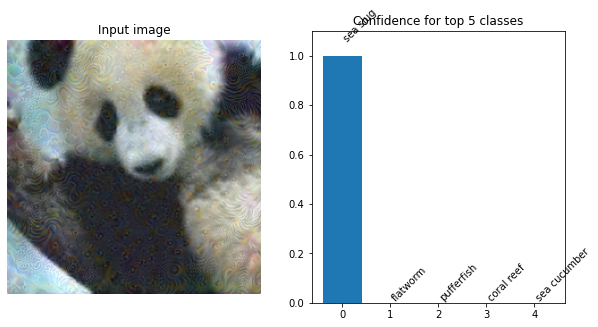

In [ ]:
perturbed_img = targeted_adversary.forward(to_tensor(panda_img).to(dev))
plot_prediction(to_pil(perturbed_img), model(perturbed_img.to(dev)))

In [ ]:
perturbation = targeted_adversary.get_noise()
evaluate_model(model, targeted_attack_test_data, perturbation, model_name='Resnet50', target_label='sea slug')

Loss  Top-1 Success rate  Top-5 Success rate
Model                                                      
Resnet50  12.402988               0.819            0.898917

The structured noise is still visible if you look for it, but
the images looks more natural than the case
where we set $\epsilon=0.20$. As we see in the table
above, lowering $\epsilon$ also caused a drop in
adversary success rate on our 12k images. However,
the success rate is still high, so there's probably
a better trade-off between visibility of noise and
adversary success rate, but I won't investigate this
further due to the computation time required to test
the different parameters.

### Fooling other networks with the same adversarial examples

We now explore the following topic

> Does the adversarial example generated for one network fool other networks, too? (~5 marks for non-minimal investigation and good writeup)

In order to investigate if the
adversarial images _fool_ some network, the network should already
be able to correctly classify the
images prior to adding adversarial
noise. I have therefore tried to
pick some models from [this torchvision list](https://pytorch.org/vision/stable/models.html) that achieve a
high Top-5 accuracy. I've chosen
the following arbitrary set of
hopefully different models:


| Model | Acc@5 |
|-------|-------|
| ResNet 50 | 92.862 |
| VGG-19 | 90.876 |
| Inception v3 | 93.450 |
| GoogleNet (Inception v1) | 89.530 |
| MNASNet 1.0 | 91.510 |
| EfficientNet-B0 | 93.532 |


I start of by downloading all the models and prepending our normalization
transformation to them. I then do a quick measure of their accuracies on
random ImageNet data out of the box, without perturbing the images.
After this, I generate perturbed images using the gradients from each of
the models one-by-one, and feed these images into all the other models,
creating some form of "confusion matrix" of the results I observe.

In [ ]:
# we first download our models
def install_models(model_names):
  # first download all the models
  ms = [getattr(models, m)(pretrained=True) for m in model_names]
  # set them all into evaluation mode
  [m.eval() for m in ms]
  # insert the normalization layer at the start of the model
  return [nn.Sequential(transform_layer(), m) for m in ms]

model_names = ['resnet50', 'vgg19', 'googlenet', 'inception_v3',
               'mnasnet1_0', 'efficientnet_b0']

mods = install_models(model_names)

In [ ]:
# Let's quickly check their Top-5 accuracy on a few ImageNet data points
some_val_data = get_dataset("val", 0.1)
print(f"There are {len(some_val_data)} data points.")

acc_df = evaluate_model(mods[0], some_val_data, model_name=model_names[0])
for mod_name, mod in zip(model_names[1:], mods[1:]):
  acc_df = pd.concat([acc_df, evaluate_model(mod, some_val_data, model_name=mod_name)])
acc_df

There are 960 data points.


Loss  Top-1 Accuracy  Top-5 Accuracy
Model                                                    
resnet50         0.504477        0.857292        0.963542
vgg19            0.663347        0.834375        0.945833
googlenet        1.038176        0.762500        0.917708
inception_v3     0.831695        0.788542        0.952083
mnasnet1_0       0.545950        0.857292        0.952083
efficientnet_b0  0.469721        0.890625        0.973958

_Figure 0: Evaluation of our models on unperturbed images._

This accuracy is higher than what was advertised in the documentation.
I suspect that the `val` split in the dataset I downloaded might just be from
some other split and that some of the models above used completely different
train-test-validation splits.

**Creating our utility function**

The objective of `get_confusion_dataframe` is to create a table where entry
$(i, j)$ gives some measure of "increase in loss" when taking structured
perturbed images we've gotten from targeting model $i$ and feeding them
to model $j$ as input, comparing it to the loss of model $j$ on the unperturbed
image. By setting `crit` as a formal parameter, we can specify any loss function
we want, such that we can also look at the top-5 accuracy difference for
instance.

In [ ]:
# we then try to make confusion matrix with FGSM noise
def get_confusion_dataframe(mods, mod_names, data, attack, epsilon, crit=nn.CrossEntropyLoss()):
  """
  Returns a dataframe of dimensions len(mods) x len(mods) where entry (i, j)
  is the difference:

      loss(model_j(img + eta), label) - loss(model_j(img), label)

  where eta is the perturbation gotten from performing attack `attack` with
  model i as the target.

  Attributes
  -------------
  mods : nn.Modules list
  mod_names : str list
  data : Dataset
  attack : fun : (Pil.Image, str, nn.Module, float) -> PIL.Image
    The attack to use for perturbation e.g. FGSM
  crit : fun : (tensor([x, 3, 224, 224]), tensor([x, 1])) -> tensor([1])
    The loss function to use when finding difference in loss when comparing
    unperturbed image to perturbed image
  """
  # initialise confusion matrix
  sum_loss_diffs = [[0.0] * len(mods) for _ in range(len(mods))]

  # prevent memory leaks when we append `loss_incrase` to an array
  with torch.no_grad():

    for i in range(len(mods)):
      mods[i] = mods[i].to(dev)

    # find perturbation by attacking model i
    for i, target_model in enumerate(mods):
      # go through all the images
      for img_tensor, label in data:
        # we need grads to perform the attack
        perturbed_img = None
        with torch.enable_grad():
          perturbed_img = attack(to_pil(img_tensor), class_id_to_name(label), target_model, epsilon)

        label = label.unsqueeze(0).to(dev)
        # then apply the perturbation to all the other models
        for j, other_model in enumerate(mods):
          # original loss
          out = other_model(img_tensor)
          loss = crit(out, label)
          # difference in loss when we have applied perturbation
          out = other_model(to_tensor(perturbed_img))
          loss_increase = crit(out, label) - loss
  
          sum_loss_diffs[i][j] += loss_increase
    
    # aggregate
    for i in range(len(mods)):
      for j in range(len(mods)):
        sum_loss_diffs[i][j] /= len(data)
    
    return pd.DataFrame(sum_loss_diffs, index=mod_names[:len(mods)], columns=mod_names[:len(mods)])

confusion_df_fgsm = get_confusion_dataframe(mods, model_names, some_val_data, fgsm_perturb_image, 0.20)

**Measuring the average drop in cross entropy loss when transfering perturbed images**

In [ ]:
confusion_df_fgsm_fixed = confusion_df_fgsm.applymap(lambda x : torch.Tensor.cpu(x).item())
confusion_df_fgsm_fixed.style.background_gradient(cmap='Blues', axis=0)

In [ ]:
confusion_df_fgsm_fixed.style.background_gradient(cmap='Blues', axis=1)

In [ ]:
confusion_df_fgsm_fixed.style.background_gradient(cmap='Blues', axis=None)

_Figures 1a, 1b, 1c: The average increase in cross entropy loss when transfering FGSM-perturbed images. The three tables have the same values, but the gradients are normalized_
_across the columns, the rows, and the whole table, respectively. The rows indicate the source model used to create the noise and the columns indicate which model we feed the perturbed image to._

In table 1a, we see that the attacks are most effective when the gradient-source
model is the same as the recipient model, with an interesting exception for
VGG-19 where perturbed images targeting efficientnet caused a greater increase
in loss.

We also observe that average increase in loss is above 4 in all the cases.
If we look back at the first table _Figure 0_, the initial loss of all
the models was below 1.1, so a four-fold increase in loss is quite big,
meaning that the FGSM attack transfered quite well regardless of which model
we sourced and which one was the recipient.






Next, we repeat the experiment with our gradient descent attack:

In [ ]:
def grad_desc_atk(input, label, model, epsilon):
  return gradient_descent_attack(input, label, model, epsilon,
                                 epochs=5, disable_printing=True)
confusion_df_gd = get_confusion_dataframe(mods, model_names, some_val_data, grad_desc_atk, 0.20)
confusion_df_gd_fixed = confusion_df_gd.applymap(lambda x : torch.Tensor.cpu(x).item())

In [ ]:
confusion_df_gd_fixed.style.background_gradient(cmap='Blues', axis=None)

_Figures 2: The average increase in cross entropy loss when transfering gradient-descent-perturbed images.  The rows indicate the source model used to create the noise and the columns indicate which model we feed the perturbed image to._

Again, we observe that we have the highest increase in loss along the
diagonal. A difference to the FGSM attack is that the loss increase in
the diagonal is a lot higher while the increase in the non-diagonals is
much lower. The `gradient_descent_attack` finds a perturbation with comparatively lower norm that does maximum harm to the
specific model it uses the gradients for, so when transfering these images,
the drop in loss is not as significant.

We still emphasize that the non-diagonal loss is at times around 0.5 or higher,
which correspond to at least 50% increased loss, which is still high.

**Measuring the average drop in top-5 accuracy when transfering perturbed images**

We can also look at the negation of top-5 accuracy as a loss function, measuring
how much the accuracy drops. We use fewer data points for this experiment since
the above tables took way too long to compute. We also set $ϵ=0.1$ (lower
than the earlier $ϵ=0.2) because this gives a wider range of accuracy drops
(0.2 was a bit too effective).

In [ ]:
bit_of_val_data = get_dataset("val", 0.02)
print(f"We have {len(bit_of_val_data)} data points")

def top_5_crit(out, label):
  p = softmax(out[0,:], dim=0)
  _, labs = p.topk(5)
  # Negate the accuracy so that we measure the _drop_ in accuracy after applying
  #   perturbation
  if label in labs:
    return -1
  else:
    return 0

top_5_acc_confusion_fgsm = get_confusion_dataframe(mods, model_names, bit_of_val_data, fgsm_perturb_image, 0.1, top_5_crit)

We have 192 data points


In [ ]:
top_5_acc_confusion_fgsm.style.background_gradient(cmap='Blues', axis=None)

In [ ]:
top_5_acc_confusion_gd = get_confusion_dataframe(mods, model_names, bit_of_val_data, grad_desc_atk, 0.1, top_5_crit)
top_5_acc_confusion_gd.style.background_gradient(cmap='Blues', axis=None)

In [ ]:
def random_noise_atk(input, label, model, epsilon):
  input = to_tensor(input).to(dev)
  return to_pil(torch.clamp(input + epsilon * torch.normal(mean=torch.zeros_like(input).to(dev)).sign(), 0, 1))
top_5_acc_confusion_random_noise = get_confusion_dataframe(mods, model_names, bit_of_val_data, random_noise_atk, 0.1, top_5_crit)

In [ ]:
top_5_acc_confusion_random_noise.style.background_gradient(cmap='Blues', axis=None)

_Figure 3a, 3b, 3c: The average drop in top-5 accuracy when transfering FGSM_
_perturbations, `gradient_descent_attack` perturbations, and adding random noise_
_(no source model), respectively._

The first two tables tell a similar story to what we observed when we looked
at the cross entropy loss drop: FGSM gives more transferable noise in terms
of causing harm, while GD noise does not transfer as well, but does more
harm along the diagonals comapred to FGSM.

Comparing table 3c to 3b, just adding random noise to the image does more harm
to a model's classification than trying to create adversarial examples using
`gradient_descent_attack` with the gradients from a different model.

Another observation is which models are more susceptable to attacks. Looking
at figures 1b, 2, and 3a, the VGG-19 and MnasNet models have a higher increase
in loss and top-5 accuracy, both when the gradient sources are themselves and
other models. Meanwhile, Inception v3 seems somewhat more resiliant to
attacks, both from FGSM and gradient descent and in both the case where it is
itself the source and when another model is the gradient source.



### Conclusions

Here, I have highlighted the key observations I made through my exploration
of adversarial attacks:
* With FGSM, we are able cause top-5 misspredictions with as low as $\epsilon=0.001$, for example on Blas, but the remaining predictions are still dog breeds in that case. To get no dog breeds in the top-5, we need higher $\epsilon$ around 0.20
* Doing targeted adversarial attacks by optimizing the direction of the perturbation with gradient descent is very effective. It gives high success rate quickly, works on many images and target labels, and produces minimal adversarial artifacts to the input image.
* In general, thinking of the perturbation as something to optimize gives a lot of flexibility: We can do targeted attacks, lower the probability mass allocated to e.g. dogs, or minimize the confidence in some arbitrary label.
* It is possible to do FGSM attacks with only blackbox queries by first estimating the gradient, and this can give top-5 misspredictions with very few queries, but it is not as _flexible_ as  `blackbox_iterated_descent`
* When performing blaxbox attacks, an effective and flexible approach is to iteratively move the perturbation in random direction, but only if it increases the loss. The flexibility of this approach even allows targeted black box attacks, but at the computational cost of many queries required.
* FGSM-perturbation are very likely to cause misspredictions when transfered to other images. This is not the case with gradient-descent-found perturbations, which have minimum effect when transfered. Howeover, better universal structured noise can be found by creating a new optimizer for it. This also allows universal targeted attacks.
* FGSM-perturbed images are likely to fool other classification networks. This cannot be said about gradient-descent-perturbed images. However, gradient-descent-perturbed images are more effective at fooling the network they used the gradients from.